In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os

# Estilo visual limpio para los gráficos
sns.set_theme(style="whitegrid")

print("Librerías listas.")

Librerías listas.


In [2]:
# ¡IMPORTANTE! Reemplaza esta ruta con la ruta a tu archivo CSV.
DATA_PATH = '../hyperparameters/grid_search_results_tateti_20250624_202015/detailed_results.csv' 

# Directorio para guardar los gráficos generados
OUTPUT_DIR = 'analisis_tateti'

# Crea el directorio de salida si no existe
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Los datos se cargarán de: {DATA_PATH}")
print(f"Los gráficos se guardarán en: {OUTPUT_DIR}")

Los datos se cargarán de: ../hyperparameters/grid_search_results_tateti_20250624_202015/detailed_results.csv
Los gráficos se guardarán en: analisis_tateti


In [3]:
def parse_and_prepare_data(filepath: str) -> pd.DataFrame:
    """
    Carga y procesa el archivo de resultados para el análisis.
    Extrae parámetros y tipos de agentes de la columna 'Configuration'.
    """
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo '{filepath}'.")
        return None

    parsed_data = []
    mcts_pattern = re.compile(r'MCTS\(S=(\d+),R=(\d+),D=(\d+)\)')
    minimax_pattern = re.compile(r'MiniMax\(D=(\d+)\)')

    for config_str in df['Configuration']:
        agent_strs = config_str.split(' vs ')
        agent_1_type = agent_strs[0].split('(')[0]
        agent_2_type = agent_strs[1].split('(')[0]
        
        params = {'S': 0, 'R': 0, 'D_mcts': 0, 'D_minimax': 0}
        
        mcts_match = mcts_pattern.search(config_str)
        if mcts_match:
            params['S'], params['R'], params['D_mcts'] = map(int, mcts_match.groups())
            
        minimax_match = minimax_pattern.search(config_str)
        if minimax_match:
            params['D_minimax'] = int(minimax_match.group(1))
            
        parsed_data.append({**params, 'agent_1_type': agent_1_type, 'agent_2_type': agent_2_type})

    params_df = pd.DataFrame(parsed_data, index=df.index)
    df_processed = pd.concat([df, params_df], axis=1)
    df_processed['matchup'] = df_processed['agent_1_type'] + ' vs ' + df_processed['agent_2_type']
    
    # Asegurarse de que el número total de juegos es consistente
    df_processed['Total Games'] = df_processed['Total Wins'] + df_processed['Total Draws'] + df_processed['Total Losses']
    
    print("Datos procesados exitosamente.")
    return df_processed

print("Función de procesamiento definida.")

Función de procesamiento definida.


In [4]:
df = parse_and_prepare_data(DATA_PATH)
if df is not None:
    print("Primeras filas del DataFrame procesado:")
    display(df.head())

Datos procesados exitosamente.
Primeras filas del DataFrame procesado:


,Configuration,Agent Role,Average Reward,Total Wins,Total Draws,Total Losses,Average Time (ms),S,R,D_mcts,D_minimax,agent_1_type,agent_2_type,matchup,Total Games
0,"MCTS(S=10,R=1,D=1) vs Random",X,0.52,37,2,11,9.734879,10,1,1,0,MCTS,Random,MCTS vs Random,50
1,"MCTS(S=10,R=1,D=1) vs Random",O,-0.52,11,2,37,0.039328,10,1,1,0,MCTS,Random,MCTS vs Random,50
2,"MCTS(S=10,R=1,D=2) vs Random",X,0.92,47,2,1,8.460501,10,1,2,0,MCTS,Random,MCTS vs Random,50
3,"MCTS(S=10,R=1,D=2) vs Random",O,-0.92,1,2,47,0.106270,10,1,2,0,MCTS,Random,MCTS vs Random,50
4,"MCTS(S=10,R=1,D=3) vs Random",X,0.74,41,5,4,8.568512,10,1,3,0,MCTS,Random,MCTS vs Random,50


## General

Generando el gráfico de resumen de victorias...
Gráfico guardado en: analisis_tateti\resumen_victorias_enfrentamientos.png


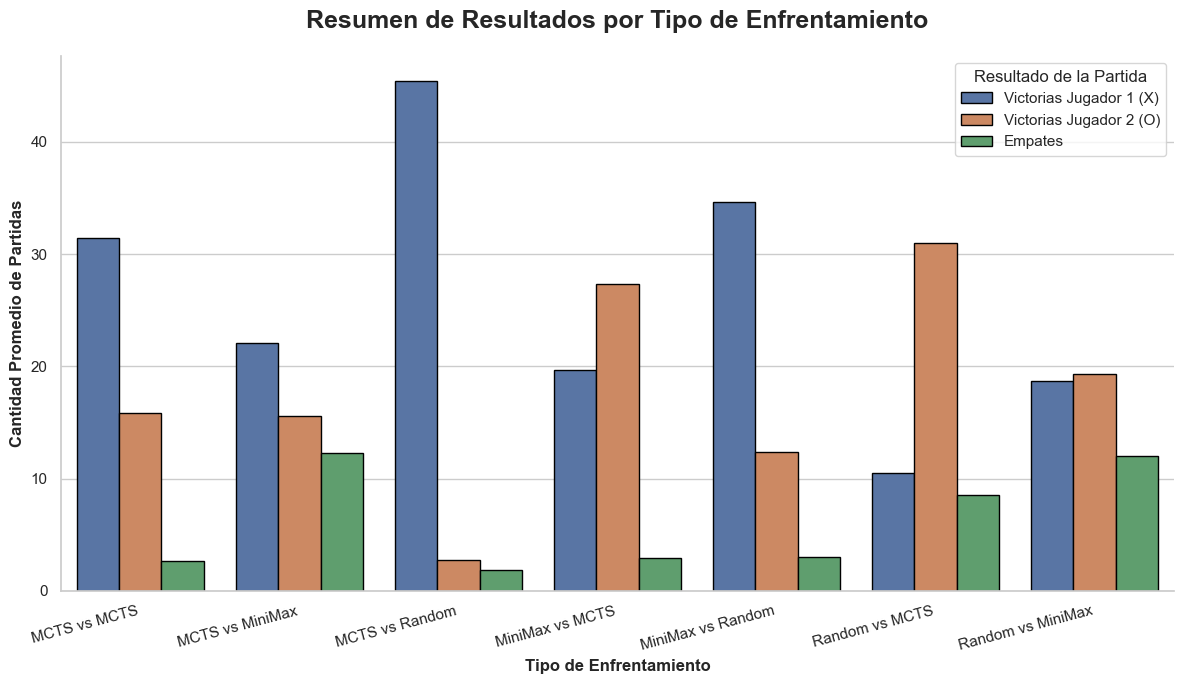

In [5]:
def plot_resumen_victorias(df: pd.DataFrame, output_dir: str):
    """
    Crea UN ÚNICO GRÁFICO de barras que muestra las victorias de X, 
    victorias de O y empates para cada tipo de enfrentamiento.
    Usa una paleta de colores simple (azul, naranja, verde).
    """
    print("Generando el gráfico de resumen de victorias...")
    
    # 1. Nos quedamos solo con las filas del Agente X para tener una entrada por configuración.
    #    La información de las victorias de O está en la columna 'Total Losses' de X.
    df_x = df[df['Agent Role'] == 'X'].copy()
    
    # 2. Agrupamos por tipo de enfrentamiento y calculamos los resultados promedio.
    summary = df_x.groupby('matchup').agg(
        victorias_x=('Total Wins', 'mean'),
        victorias_o=('Total Losses', 'mean'), # Las derrotas de X son las victorias de O
        empates=('Total Draws', 'mean')
    ).reset_index()

    # 3. Reorganizamos los datos al formato "largo" que necesita seaborn para agrupar barras.
    summary_melted = summary.melt(
        id_vars='matchup', 
        var_name='Resultado', 
        value_name='Cantidad Promedio'
    )
    
    # 4. Creamos el gráfico.
    plt.figure(figsize=(12, 7))
    
    # Paleta de colores clásica y explícita: Azul, Naranja, Verde.
    color_map = {
        "victorias_x": "C0", # Azul
        "victorias_o": "C1", # Naranja
        "empates": "C2"      # Verde
    }
    
    barplot = sns.barplot(
        data=summary_melted, 
        x='matchup', 
        y='Cantidad Promedio', 
        hue='Resultado',
        palette=color_map, # Usamos nuestra paleta de colores definida
        edgecolor='black'
    )

    # 5. Añadimos los detalles para que sea una "linda gráfica".
    plt.title('Resumen de Resultados por Tipo de Enfrentamiento', fontsize=18, weight='bold', pad=20)
    plt.xlabel('Tipo de Enfrentamiento', fontsize=12, weight='bold')
    plt.ylabel('Cantidad Promedio de Partidas', fontsize=12, weight='bold')
    plt.xticks(rotation=15, ha='right', fontsize=11)
    plt.yticks(fontsize=11)
    sns.despine() # Quita los bordes superiores y derechos.
    
    # Personalizamos la leyenda para que sea más clara.
    handles, labels = barplot.get_legend_handles_labels()
    new_labels = ['Victorias Jugador 1 (X)', 'Victorias Jugador 2 (O)', 'Empates']
    barplot.legend(handles=handles, labels=new_labels, title='Resultado de la Partida', fontsize=11)
    
    plt.tight_layout()
    
    # Guardar la figura.
    output_path = os.path.join(output_dir, "resumen_victorias_enfrentamientos.png")
    plt.savefig(output_path, dpi=300)
    print(f"Gráfico guardado en: {output_path}")
    
    plt.show()

# --- Ejecución ---
# Llamamos a la función con el DataFrame 'df' que ya tienes cargado y procesado.
if 'df' in locals():
    plot_resumen_victorias(df, OUTPUT_DIR)
else:
    print("Error: El DataFrame 'df' no está definido. Asegúrate de ejecutar las celdas anteriores.")

## Random vs Minimax (y viceversa)

-> Creando Dashboard de Rendimiento para: MiniMax (X) vs. Random (O)


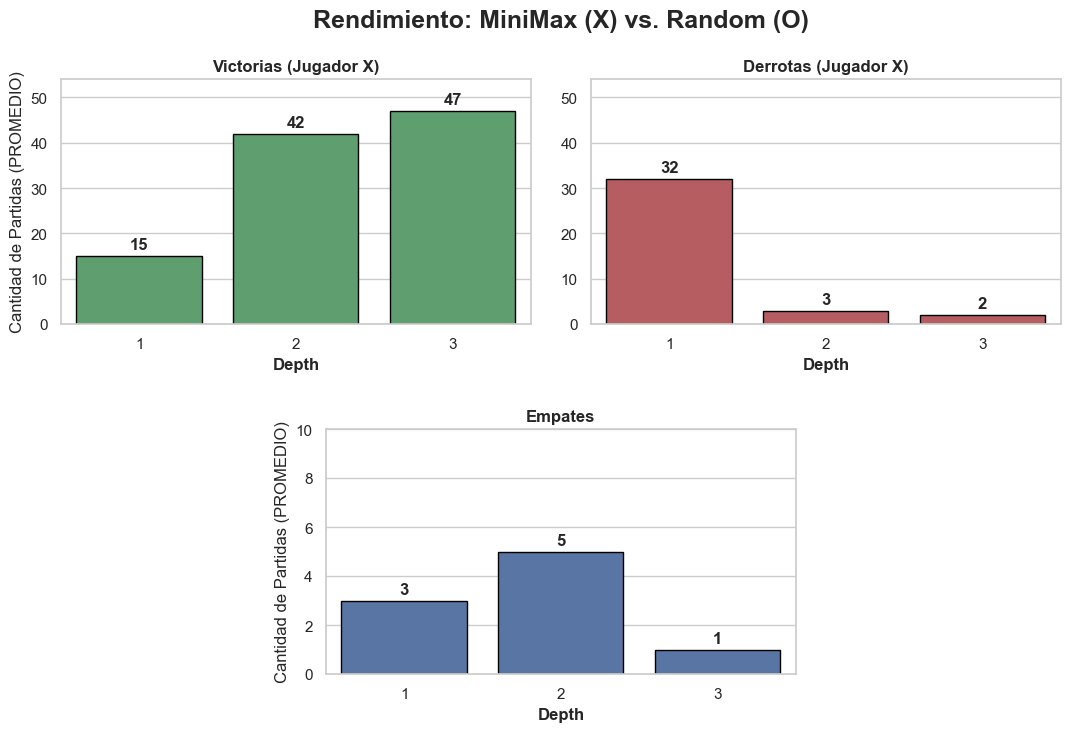

   -> Dashboard guardado en: analisis_tateti\dashboard_MiniMax_vs_Random.png
-> Creando Dashboard de Rendimiento para: Random (X) vs. MiniMax (O)


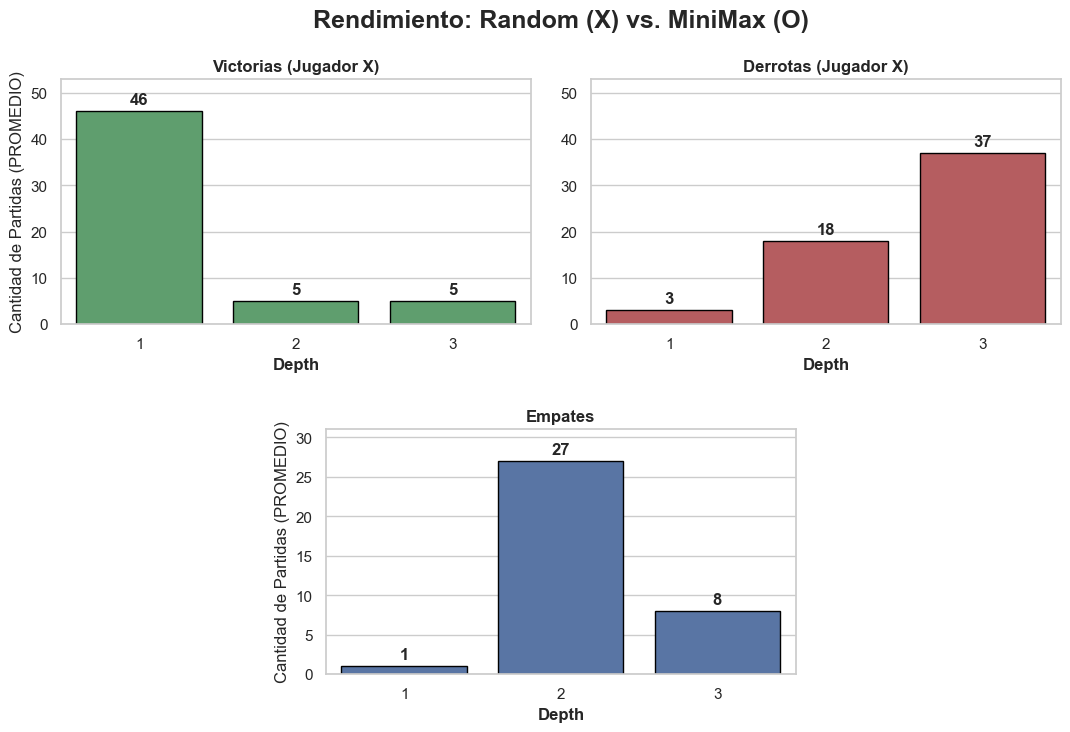

   -> Dashboard guardado en: analisis_tateti\dashboard_Random_vs_MiniMax.png
-> Gráfico 2: Analizando coste computacional de Minimax...


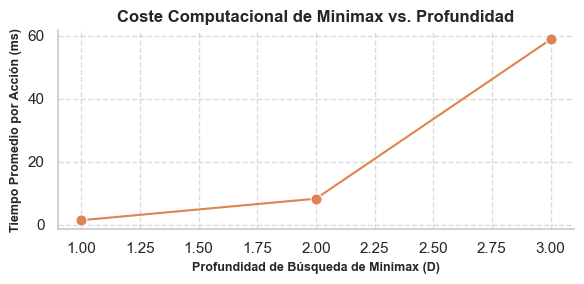

-> Gráfico 3: Comparando rendimiento de Minimax como Jugador X vs. O...


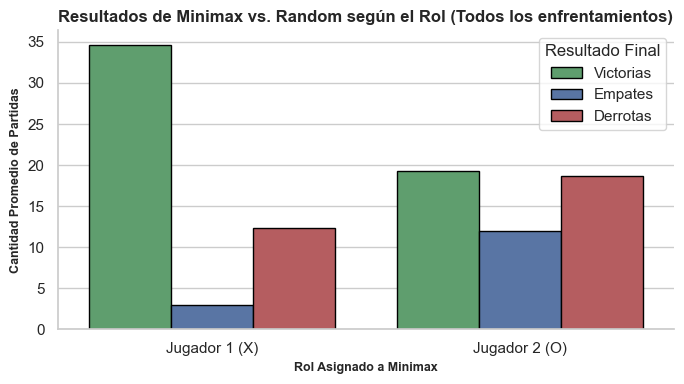

In [27]:
# --- ANÁLISIS ENFOCADO: MINIMAX VS RANDOM (VERSIÓN CORREGIDA) ---

# Filtramos el DataFrame para quedarnos solo con los enfrentamientos relevantes
df_minimax_vs_random = df[df['matchup'].isin(['MiniMax vs Random', 'Random vs MiniMax'])].copy()
#ignore when its 0
df_minimax_vs_random = df_minimax_vs_random[df_minimax_vs_random['D_minimax'] > 0]

#save the filtered DataFrame to a CSV file
df_minimax_vs_random.to_csv(os.path.join(OUTPUT_DIR, 'minimax_vs_random_filtered.csv'), index=False)

if df_minimax_vs_random.empty:
    print("No se encontraron datos para el enfrentamiento 'Minimax vs Random'.")
else:
    # --- GRÁFICO 1: El Rendimiento de Minimax según su Profundidad ---

    def plot_dashboard_rendimiento(
            data: pd.DataFrame,
            agent_x_name: str,
            opponent_name: str,
            param_col: str,
            output_dir: str
        ):
        """
        Dashboard 3-en-1 (cada subplot ≈5×3):
            ┌─────────────┬─────────────┐
            │  Victorias  │  Derrotas   │
            └─────────────┴─────────────┐
                    Empates          │
            └───────────────────────────┘
        """

        print(f"-> Creando Dashboard de Rendimiento para: {agent_x_name} (X) vs. {opponent_name} (O)")

        matchup_str = f"{agent_x_name} vs {opponent_name}"
        data_x = data[(data['matchup'] == matchup_str) & (data['Agent Role'] == 'X')].copy()

        if data_x.empty or data_x[param_col].nunique() == 0:
            print(f"   -> No se encontraron datos para el enfrentamiento '{matchup_str}' con el parámetro '{param_col}'.")
            return

        # ────────────── FIGURA & POSICIONES MANUALES ──────────────
        # 2×5 (arriba) + 3 (abajo)  → altura total ≈7
        fig = plt.figure(figsize=(10, 7))

        # (x0, y0, width, height)   — coordenadas relativas [0,1]
        ax_wins   = fig.add_axes([0.00, 0.55, 0.47, 0.35])   # Izq arriba
        ax_losses = fig.add_axes([0.53, 0.55, 0.47, 0.35])   # Der arriba
        ax_draws  = fig.add_axes([0.265, 0.05, 0.47, 0.35])  # Centro abajo

        # Colores
        color_victorias = 'C2'
        color_derrotas  = 'C3'
        color_empates   = 'C0'

        # Escala Y común para victorias/derrotas
        max_y = max(data_x['Total Wins'].max(), data_x['Total Losses'].max()) * 1.15

        # ─── VICTORIAS ──────────────────────────────────────────
        sns.barplot(
            data=data_x, x=param_col, y='Total Wins',
            color=color_victorias, edgecolor='black',
            errorbar=None, ax=ax_wins
        )
        ax_wins.set_title('Victorias (Jugador X)', weight='bold')
        ax_wins.set_xlabel(f'Depth', weight='bold')
        ax_wins.set_ylabel('Cantidad de Partidas (PROMEDIO)')
        ax_wins.set_ylim(0, max_y)

        # ─── DERROTAS ───────────────────────────────────────────
        sns.barplot(
            data=data_x, x=param_col, y='Total Losses',
            color=color_derrotas, edgecolor='black',
            errorbar=None, ax=ax_losses
        )
        ax_losses.set_title('Derrotas (Jugador X)', weight='bold')
        ax_losses.set_xlabel('')
        ax_losses.set_xlabel(f'Depth', weight='bold')

        ax_losses.set_ylabel('')
        ax_losses.set_ylim(0, max_y)

        # ─── EMPATES ────────────────────────────────────────────
        sns.barplot(
            data=data_x, x=param_col, y='Total Draws',
            color=color_empates, edgecolor='black',
            errorbar=None, ax=ax_draws
        )
        ax_draws.set_title('Empates', weight='bold')
        ax_draws.set_xlabel(f'Depth', weight='bold')
        ax_draws.set_ylabel('Cantidad de Partidas (PROMEDIO)')
        ax_draws.set_ylim(0, max(10, data_x['Total Draws'].max() * 1.15))

        # ─── Anotaciones ───────────────────────────────────────
        for ax in (ax_wins, ax_losses, ax_draws):
            for p in ax.patches:
                ax.annotate(
                    f"{p.get_height():.0f}",
                    (p.get_x() + p.get_width() / 2.0, p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 8), textcoords='offset points',
                    weight='bold'
                )

        # ─── Título general ────────────────────────────────────
        fig.suptitle(
            f'Rendimiento: {agent_x_name} (X) vs. {opponent_name} (O)',
            fontsize=18, weight='bold', y=1   # y=0.98 → más margen superior
        )

        # Guardar y mostrar
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(
            output_dir, f"dashboard_{agent_x_name}_vs_{opponent_name}.png"
        )
        plt.savefig(output_path, dpi=300)
        plt.show()

        print(f"   -> Dashboard guardado en: {output_path}")


    # --- GRÁFICO 2: El Coste Computacional de la Profundidad ---
    def plot_coste_minimax(data: pd.DataFrame, output_dir: str):
        """Muestra cómo el tiempo de cómputo de Minimax crece con la profundidad."""
        print("-> Gráfico 2: Analizando coste computacional de Minimax...")
        
        data_x = data[data['agent_1_type'] == 'MiniMax'].copy()
        
        if data_x.empty:
            print("   -> No hay datos de 'Minimax vs Random' para este gráfico.")
            return

        plt.figure(figsize=(6, 3))
        lineplot = sns.lineplot(data=data_x, x='D_minimax', y='Average Time (ms)', 
                                marker='o', markersize=8, color='C1', errorbar=None)
                                
        plt.title('Coste Computacional de Minimax vs. Profundidad', fontsize=12, weight='bold')
        plt.xlabel('Profundidad de Búsqueda de Minimax (D)', fontsize=9, weight='bold')
        plt.ylabel('Tiempo Promedio por Acción (ms)', fontsize=9, weight='bold')
        plt.grid(True, which='both', linestyle='--', alpha=0.7)
        sns.despine()
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "minimax_2_coste_por_profundidad.png"), dpi=300)
        plt.show()

    # --- GRÁFICO 3: Comparación de Roles (CORREGIDO) ---
    def plot_comparacion_roles_minimax(data: pd.DataFrame, output_dir: str):
        """Compara los resultados de Minimax cuando juega primero vs. cuando juega segundo."""
        print("-> Gráfico 3: Comparando rendimiento de Minimax como Jugador X vs. O...")
        
        summary_list = []
        
        # Caso 1: Minimax es Jugador 1 (X)
        subset_x = data[data['matchup'] == 'MiniMax vs Random']
        if not subset_x.empty:
            # Aquí, las victorias de Minimax son las 'Total Wins' del Agente X
            avg_wins = subset_x[subset_x['Agent Role'] == 'X']['Total Wins'].mean()
            avg_draws = subset_x[subset_x['Agent Role'] == 'X']['Total Draws'].mean()
            avg_losses = subset_x[subset_x['Agent Role'] == 'X']['Total Losses'].mean()
            summary_list.append({'Rol de Minimax': 'Jugador 1 (X)', 'Resultado': 'Victorias', 'Cantidad': avg_wins})
            summary_list.append({'Rol de Minimax': 'Jugador 1 (X)', 'Resultado': 'Empates', 'Cantidad': avg_draws})
            summary_list.append({'Rol de Minimax': 'Jugador 1 (X)', 'Resultado': 'Derrotas', 'Cantidad': avg_losses})

        # Caso 2: Minimax es Jugador 2 (O)
        subset_o = data[data['matchup'] == 'Random vs MiniMax']
        if not subset_o.empty:
            # Aquí, las victorias de Minimax son las 'Total Losses' del Agente X (Random)
            avg_wins = subset_o[subset_o['Agent Role'] == 'X']['Total Losses'].mean()
            avg_draws = subset_o[subset_o['Agent Role'] == 'X']['Total Draws'].mean()
            avg_losses = subset_o[subset_o['Agent Role'] == 'X']['Total Wins'].mean()
            summary_list.append({'Rol de Minimax': 'Jugador 2 (O)', 'Resultado': 'Victorias', 'Cantidad': avg_wins})
            summary_list.append({'Rol de Minimax': 'Jugador 2 (O)', 'Resultado': 'Empates', 'Cantidad': avg_draws})
            summary_list.append({'Rol de Minimax': 'Jugador 2 (O)', 'Resultado': 'Derrotas', 'Cantidad': avg_losses})

        if not summary_list:
            print("   -> No hay datos suficientes para el gráfico de comparación de roles.")
            return
            
        summary_df = pd.DataFrame(summary_list)
        
        plt.figure(figsize=(7, 4))
        sns.barplot(data=summary_df, x='Rol de Minimax', y='Cantidad', hue='Resultado',
                    edgecolor='black', palette=['C2', 'C0', 'C3']) # Azul, Verde, Rojo
        
        plt.title('Resultados de Minimax vs. Random según el Rol (Todos los enfrentamientos)', fontsize=12, weight='bold')
        plt.xlabel('Rol Asignado a Minimax', fontsize=9, weight='bold')
        plt.ylabel('Cantidad Promedio de Partidas', fontsize=9, weight='bold')
        plt.legend(title='Resultado Final')
        sns.despine()
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "minimax_3_comparacion_roles.png"), dpi=300)
        plt.show()

    # --- Ejecución de los análisis ---
    plot_dashboard_rendimiento(df, 
                               agent_x_name='MiniMax', 
                               opponent_name='Random', 
                               param_col='D_minimax',  # El parámetro que varía es el del propio Minimax
                               output_dir=OUTPUT_DIR)

    # Dashboard 2: Cuando Random es el Jugador X (y Minimax es el oponente)
    plot_dashboard_rendimiento(df, 
                               agent_x_name='Random', 
                               opponent_name='MiniMax', 
                               param_col='D_minimax', # El parámetro que varía sigue siendo el de Minimax
                               output_dir=OUTPUT_DIR)
        
    plot_coste_minimax(df_minimax_vs_random, OUTPUT_DIR)
    plot_comparacion_roles_minimax(df_minimax_vs_random, OUTPUT_DIR)

## Random vs MCST (y viceversa)

-> Creando Dashboard de Rendimiento para: MCTS (X) vs. Random (O)


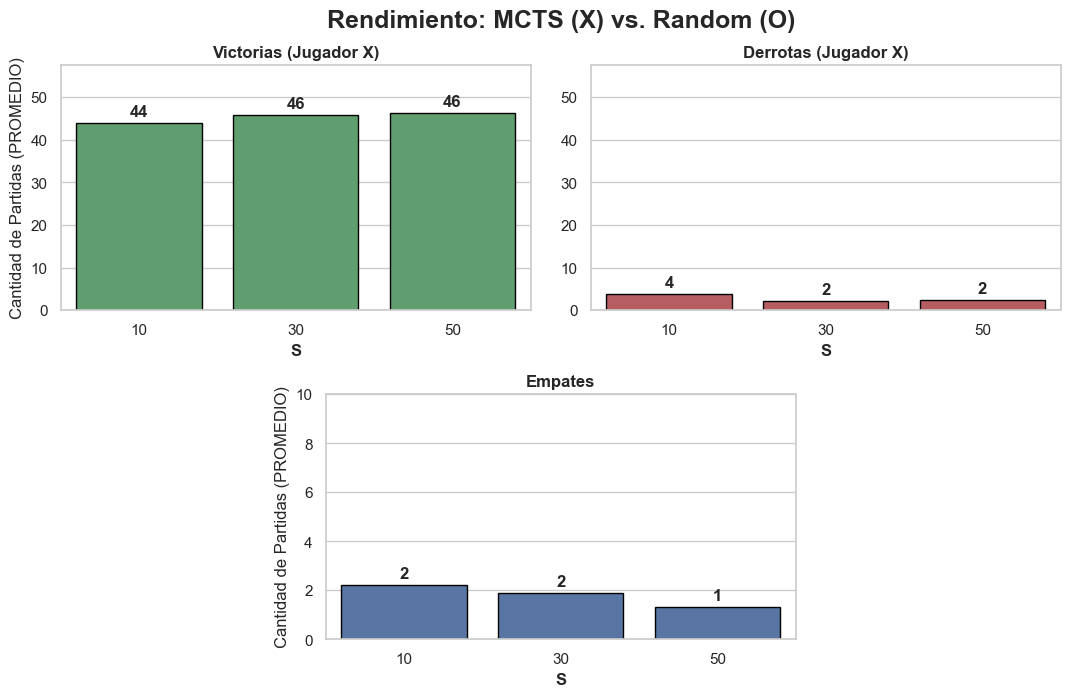

   -> Dashboard guardado en: analisis_tateti\dashboard_MCTS_vs_Random.png
-> Creando Dashboard de Rendimiento para: MCTS (X) vs. Random (O)


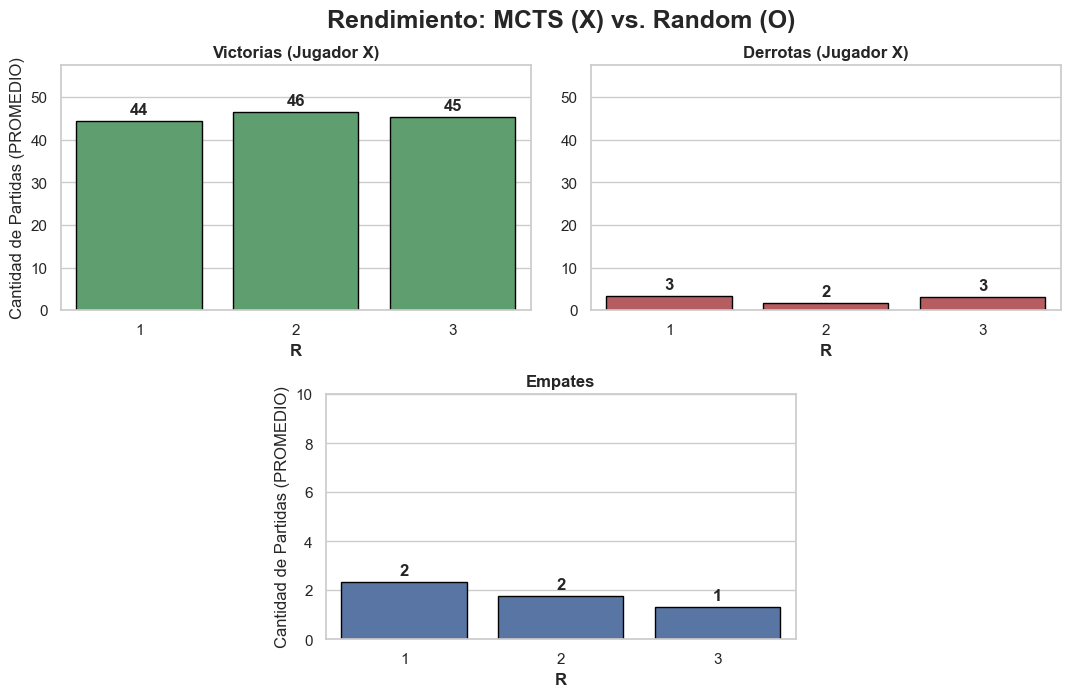

   -> Dashboard guardado en: analisis_tateti\dashboard_MCTS_vs_Random.png
-> Creando Dashboard de Rendimiento para: MCTS (X) vs. Random (O)


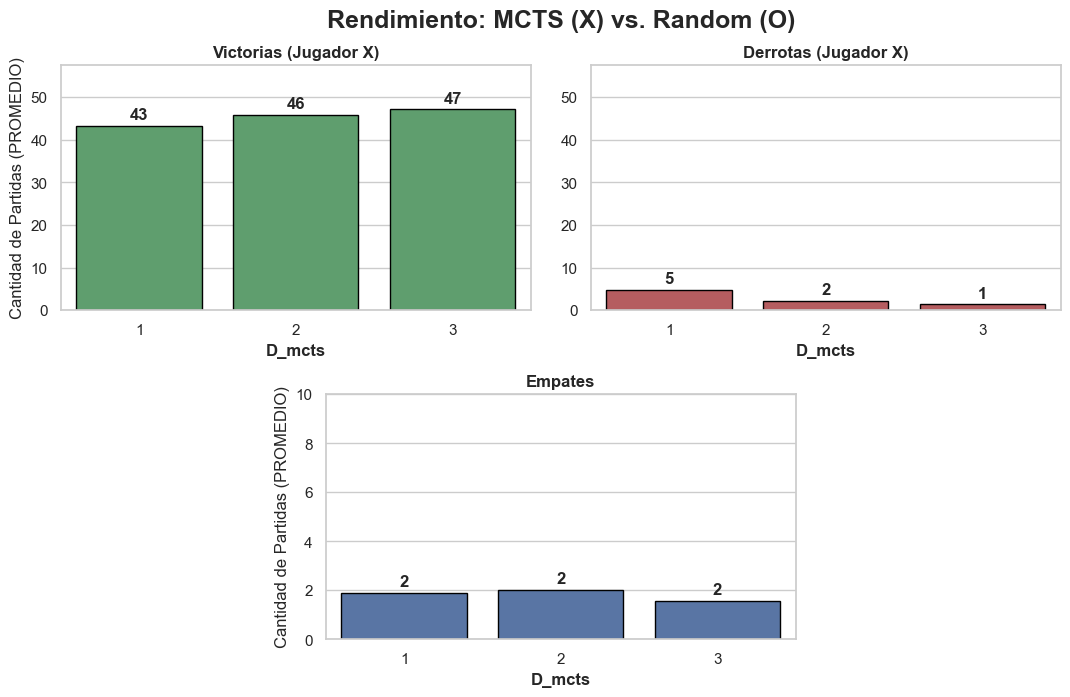

   -> Dashboard guardado en: analisis_tateti\dashboard_MCTS_vs_Random.png
-> Creando Dashboard de Rendimiento para: Random (X) vs. MCTS (O)


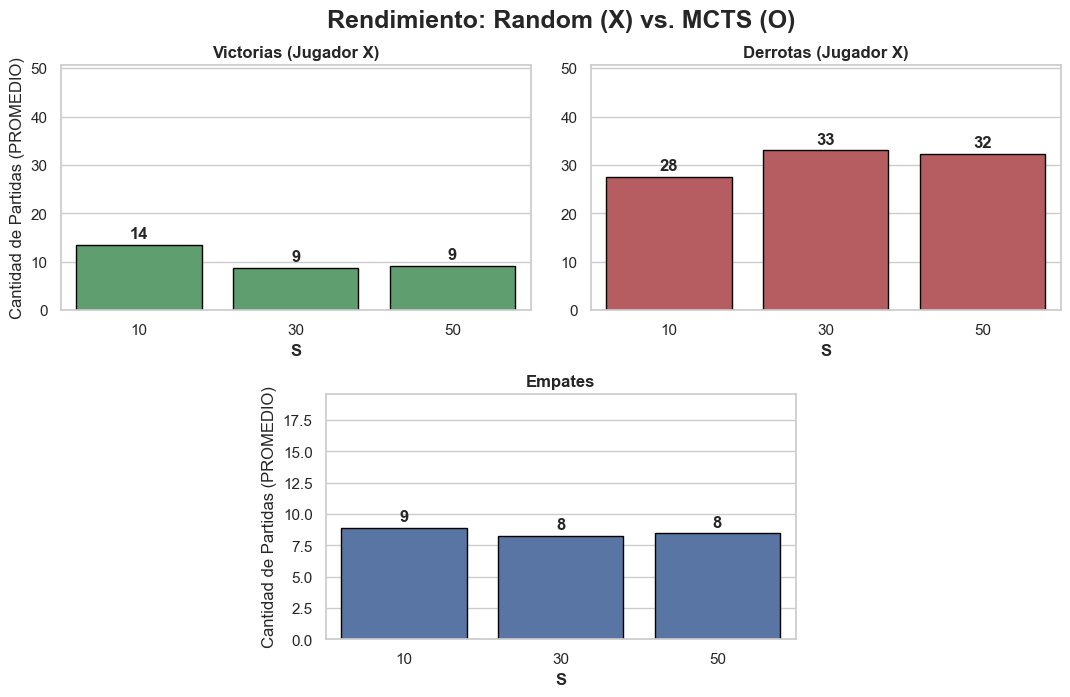

   -> Dashboard guardado en: analisis_tateti\dashboard_Random_vs_MCTS.png
-> Creando Dashboard de Rendimiento para: Random (X) vs. MCTS (O)


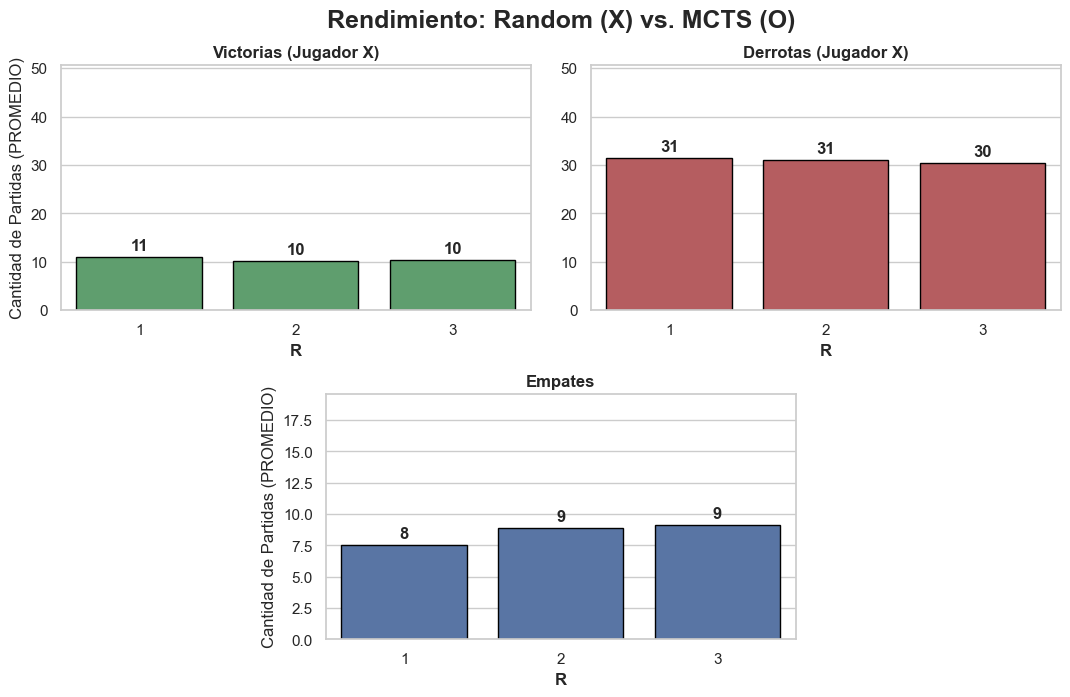

   -> Dashboard guardado en: analisis_tateti\dashboard_Random_vs_MCTS.png
-> Creando Dashboard de Rendimiento para: Random (X) vs. MCTS (O)


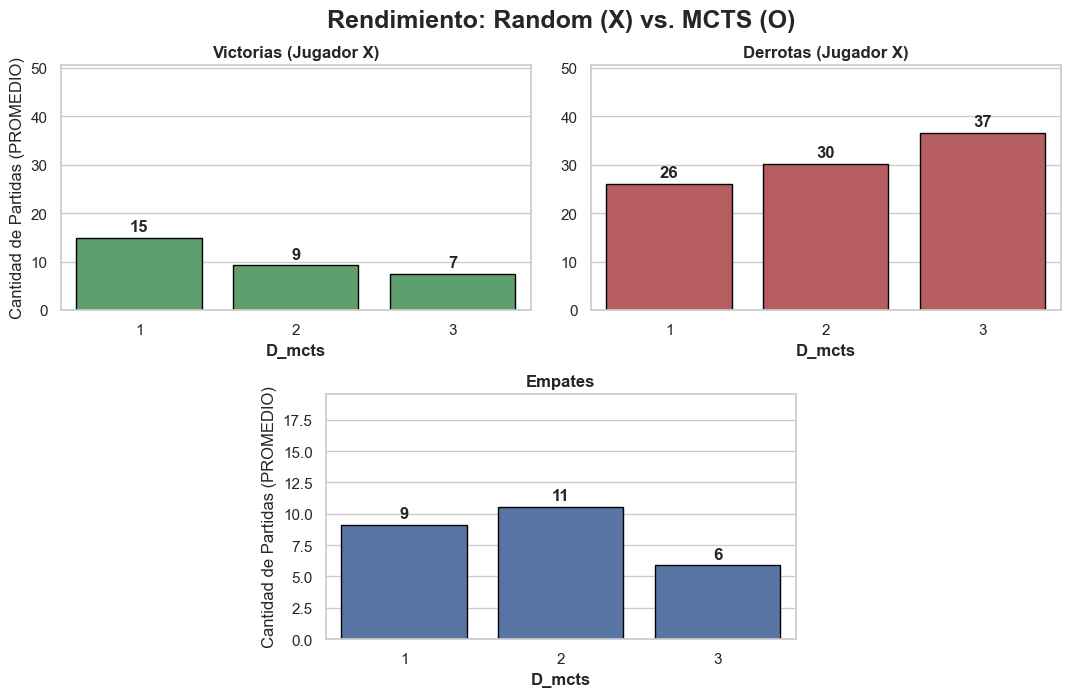

   -> Dashboard guardado en: analisis_tateti\dashboard_Random_vs_MCTS.png
-> Gráfico 2: Coste computacional de MCTS + victorias…


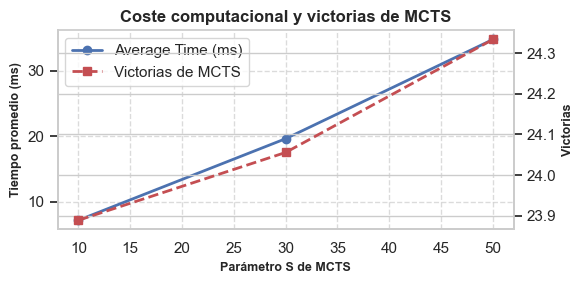

   -> Gráfico guardado en: analisis_tateti\mcts_coste_vs_S.png
-> Gráfico 2: Coste computacional de MCTS + victorias…


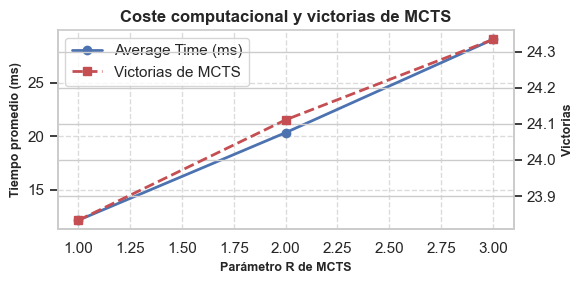

   -> Gráfico guardado en: analisis_tateti\mcts_coste_vs_R.png
-> Gráfico 2: Coste computacional de MCTS + victorias…


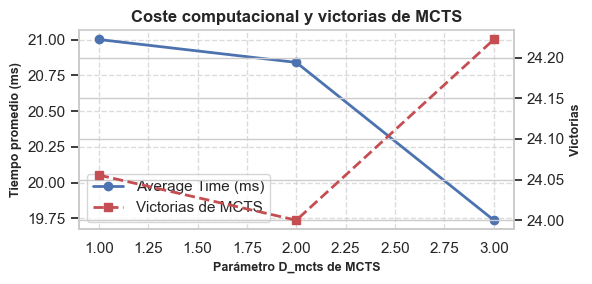

   -> Gráfico guardado en: analisis_tateti\mcts_coste_vs_D_mcts.png
-> Gráfico 3: Comparando MCTS como Jugador X vs O…


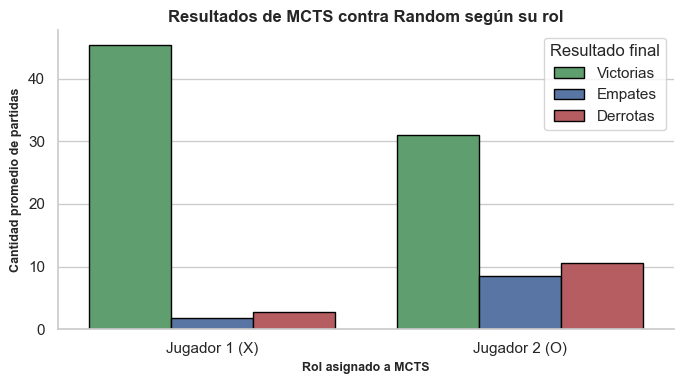

   -> Gráfico guardado en: analisis_tateti\mcts_comparacion_roles.png


In [28]:
# 2) Filtrar: MCTS vs Random (ignora registros con S == 0)
# ------------------------------------------------------------
df_mcts_vs_random = df[df["matchup"].isin(["MCTS vs Random", "Random vs MCTS"])].copy()
df_mcts_vs_random = df_mcts_vs_random[df_mcts_vs_random["S"] > 0]

#save the filtered DataFrame to a CSV file
df_mcts_vs_random.to_csv(os.path.join(OUTPUT_DIR, 'mcts_vs_random_filtered.csv'), index=False)

if df_mcts_vs_random.empty:
    print("No se encontraron datos para el enfrentamiento 'MCTS vs Random'.")
else:

    # --------------------------------------------------------
    # 2-A) DASHBOARD RENDIMIENTO
    # --------------------------------------------------------
    def plot_dashboard_rendimiento(
            data: pd.DataFrame,
            agent_x_name: str,
            opponent_name: str,
            param_col: str,
            output_dir: str
        ):
        """
        Dashboard 3-en-1 (subplots ≈5×3):
            ┌─────────────┬─────────────┐
            │  Victorias  │  Derrotas   │
            └─────────────┴─────────────┐
                      Empates           │
            └───────────────────────────┘
        """
        print(f"-> Creando Dashboard de Rendimiento para: {agent_x_name} (X) vs. {opponent_name} (O)")

        matchup_str = f"{agent_x_name} vs {opponent_name}"
        data_x = data[(data["matchup"] == matchup_str) & (data["Agent Role"] == "X")].copy()

        if data_x.empty or data_x[param_col].nunique() == 0:
            print(f"   -> No se encontraron datos para '{matchup_str}' con parámetro '{param_col}'.")
            return

        # ---- FIGURA Y EJES (5×3 cada uno) -------------------
        fig = plt.figure(figsize=(10, 7))
        ax_wins   = fig.add_axes([0.00, 0.55, 0.47, 0.35])
        ax_losses = fig.add_axes([0.53, 0.55, 0.47, 0.35])
        ax_draws  = fig.add_axes([0.265, 0.08, 0.47, 0.35])

        # Colores
        color_victorias = "C2"
        color_derrotas  = "C3"
        color_empates   = "C0"

        max_y = max(data_x["Total Wins"].max(), data_x["Total Losses"].max()) * 1.15

        # ---- Victories -------------------------------------
        sns.barplot(data=data_x, x=param_col, y="Total Wins",
                    color=color_victorias, edgecolor="black", errorbar=None, ax=ax_wins)
        ax_wins.set_title("Victorias (Jugador X)", weight="bold")
        ax_wins.set_xlabel(param_col, weight="bold")
        ax_wins.set_ylabel("Cantidad de Partidas (PROMEDIO)")
        ax_wins.set_ylim(0, max_y)

        # ---- Losses ----------------------------------------
        sns.barplot(data=data_x, x=param_col, y="Total Losses",
                    color=color_derrotas, edgecolor="black", errorbar=None, ax=ax_losses)
        ax_losses.set_title("Derrotas (Jugador X)", weight="bold")
        ax_losses.set_xlabel(param_col, weight="bold")
        ax_losses.set_ylabel("")
        ax_losses.set_ylim(0, max_y)

        # ---- Draws -----------------------------------------
        sns.barplot(data=data_x, x=param_col, y="Total Draws",
                    color=color_empates, edgecolor="black", errorbar=None, ax=ax_draws)
        ax_draws.set_title("Empates", weight="bold")
        ax_draws.set_xlabel(param_col, weight="bold")
        ax_draws.set_ylabel("Cantidad de Partidas (PROMEDIO)")
        ax_draws.set_ylim(0, max(10, data_x["Total Draws"].max() * 1.15))

        # ---- Anotaciones -----------------------------------
        for ax in (ax_wins, ax_losses, ax_draws):
            for p in ax.patches:
                ax.annotate(f"{p.get_height():.0f}",
                            (p.get_x() + p.get_width() / 2.0, p.get_height()),
                            ha="center", va="center",
                            xytext=(0, 8), textcoords="offset points",
                            weight="bold")

        fig.suptitle(f"Rendimiento: {agent_x_name} (X) vs. {opponent_name} (O)",
                     fontsize=18, weight="bold", y=0.98)

        os.makedirs(output_dir, exist_ok=True)
        out = os.path.join(output_dir, f"dashboard_{agent_x_name}_vs_{opponent_name}.png")
        plt.savefig(out, dpi=300)
        plt.show()
        print(f"   -> Dashboard guardado en: {out}")

    # --------------------------------------------------------
    # 2-B) COSTE COMPUTACIONAL (S → Average Time)
    # --------------------------------------------------------
    def plot_coste_mcts(data: pd.DataFrame, param_col: str, output_dir: str):
        """
        Gráfico dual:
            • Línea 1: Average Time (ms)  ─ eje Y primario
            • Línea 2: Total Wins         ─ eje Y secundario
        """
        print("-> Gráfico 2: Coste computacional de MCTS + victorias…")

        # Solo partidas donde MCTS es el primer agente (MCTS vs Random)
        data_x = data[data["agent_1_type"] == "MCTS"].copy()
        if data_x.empty:
            print("   -> No hay datos de 'MCTS vs Random' para este gráfico.")
            return

        # Agrupamos por el parámetro y promediamos
        agg = (
            data_x
            .groupby(param_col, as_index=False)
            .agg({"Average Time (ms)": "mean", "Total Wins": "mean"})
            .sort_values(param_col)
        )

        # ────────── FIGURA ──────────
        fig, ax_time = plt.subplots(figsize=(6, 3))

        # Curva 1: Tiempo
        line1 = ax_time.plot(
            agg[param_col], agg["Average Time (ms)"],
            marker="o", linewidth=2, label="Average Time (ms)"
        )
        ax_time.set_xlabel(f"Parámetro {param_col} de MCTS", fontsize=9, weight="bold")
        ax_time.set_ylabel("Tiempo promedio (ms)", fontsize=9, weight="bold")
        ax_time.grid(True, linestyle="--", alpha=0.7)

        # Curva 2: Victorias (eje secundario)
        ax_wins = ax_time.twinx()
        line2 = ax_wins.plot(
            agg[param_col], agg["Total Wins"],
            marker="s", linestyle="--", linewidth=2, color="C3",
            label="Victorias de MCTS"
        )
        ax_wins.set_ylabel("Victorias", fontsize=9, weight="bold")

        # Unir leyendas
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax_time.legend(lines, labels, loc="best")

        plt.title("Coste computacional y victorias de MCTS", fontsize=12, weight="bold")
        sns.despine(ax=ax_time, right=False)  # dejamos spines p/ambos ejes
        plt.tight_layout()

        out = os.path.join(output_dir, f"mcts_coste_vs_{param_col}.png")
        plt.savefig(out, dpi=300)
        plt.show()
        print(f"   -> Gráfico guardado en: {out}")

    # --------------------------------------------------------
    # 2-C) COMPARACIÓN DE ROLES
    # --------------------------------------------------------
    def plot_comparacion_roles_mcts(data: pd.DataFrame, output_dir: str):
        print("-> Gráfico 3: Comparando MCTS como Jugador X vs O…")

        summary = []

        # Caso 1: MCTS es Jugador X
        subset_x = data[data["matchup"] == "MCTS vs Random"]
        if not subset_x.empty:
            avg_wins   = subset_x[subset_x["Agent Role"] == "X"]["Total Wins"  ].mean()
            avg_draws  = subset_x[subset_x["Agent Role"] == "X"]["Total Draws" ].mean()
            avg_losses = subset_x[subset_x["Agent Role"] == "X"]["Total Losses"].mean()
            summary += [
                {"Rol MCTS": "Jugador 1 (X)", "Resultado": "Victorias", "Cantidad": avg_wins},
                {"Rol MCTS": "Jugador 1 (X)", "Resultado": "Empates",   "Cantidad": avg_draws},
                {"Rol MCTS": "Jugador 1 (X)", "Resultado": "Derrotas",  "Cantidad": avg_losses},
            ]

        # Caso 2: MCTS es Jugador O
        subset_o = data[data["matchup"] == "Random vs MCTS"]
        if not subset_o.empty:
            avg_wins   = subset_o[subset_o["Agent Role"] == "X"]["Total Losses"].mean()
            avg_draws  = subset_o[subset_o["Agent Role"] == "X"]["Total Draws" ].mean()
            avg_losses = subset_o[subset_o["Agent Role"] == "X"]["Total Wins"  ].mean()
            summary += [
                {"Rol MCTS": "Jugador 2 (O)", "Resultado": "Victorias", "Cantidad": avg_wins},
                {"Rol MCTS": "Jugador 2 (O)", "Resultado": "Empates",   "Cantidad": avg_draws},
                {"Rol MCTS": "Jugador 2 (O)", "Resultado": "Derrotas",  "Cantidad": avg_losses},
            ]

        if not summary:
            print("   -> No hay datos para comparar roles.")
            return

        summary_df = pd.DataFrame(summary)
        plt.figure(figsize=(7, 4))
        sns.barplot(data=summary_df, x="Rol MCTS", y="Cantidad", hue="Resultado",
                    edgecolor="black", palette=["C2", "C0", "C3"])

        plt.title("Resultados de MCTS contra Random según su rol", fontsize=12, weight="bold")
        plt.xlabel("Rol asignado a MCTS", fontsize=9, weight="bold")
        plt.ylabel("Cantidad promedio de partidas", fontsize=9, weight="bold")
        plt.legend(title="Resultado final")
        sns.despine()
        plt.tight_layout()

        out = os.path.join(output_dir, "mcts_comparacion_roles.png")
        plt.savefig(out, dpi=300)
        plt.show()
        print(f"   -> Gráfico guardado en: {out}")

    # --------------------------------------------------------
    # 3) EJECUTAR LOS GRÁFICOS
    # --------------------------------------------------------
    # Dashboard cuando MCTS es X
    plot_dashboard_rendimiento(df,
                               agent_x_name="MCTS",
                               opponent_name="Random",
                               param_col="S",          # cambia a 'R' o 'D_mcts' si es tu parámetro
                               output_dir=OUTPUT_DIR)
    
    plot_dashboard_rendimiento(df,
                               agent_x_name="MCTS",
                               opponent_name="Random",
                               param_col="R",          # cambia a 'R' o 'D_mcts' si es tu parámetro
                               output_dir=OUTPUT_DIR)
    
    plot_dashboard_rendimiento(df,
                               agent_x_name="MCTS",
                               opponent_name="Random",
                               param_col="D_mcts",          # cambia a 'R' o 'D_mcts' si es tu parámetro
                               output_dir=OUTPUT_DIR)

    # Dashboard cuando Random es X
    plot_dashboard_rendimiento(df,
                               agent_x_name="Random",
                               opponent_name="MCTS",
                               param_col="S",
                               output_dir=OUTPUT_DIR)
    
    plot_dashboard_rendimiento(df,
                               agent_x_name="Random",
                               opponent_name="MCTS",
                               param_col="R",
                               output_dir=OUTPUT_DIR)
    
    plot_dashboard_rendimiento(df,
                               agent_x_name="Random",
                               opponent_name="MCTS",
                               param_col="D_mcts",
                               output_dir=OUTPUT_DIR)


    # Coste computacional
    plot_coste_mcts(df_mcts_vs_random, param_col="S", output_dir=OUTPUT_DIR)
    plot_coste_mcts(df_mcts_vs_random, param_col="R", output_dir=OUTPUT_DIR)
    plot_coste_mcts(df_mcts_vs_random, param_col="D_mcts", output_dir=OUTPUT_DIR)

    # Comparación roles
    plot_comparacion_roles_mcts(df_mcts_vs_random, output_dir=OUTPUT_DIR)

In [8]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_frente_eficiencia_mcts_dashboard(
        data: pd.DataFrame,
        depths: list[int],            # EXACTAMENTE tres valores, ej. [3,4,5]
        output_dir: str,
        figsize=(10, 7)
    ):
    """
    Tres frentes de eficiencia (uno por D_mcts) con layout:
        ┌─────────────┬─────────────┐
        │  D = d₁     │  D = d₂     │
        └─────────────┴─────────────┐
                   D = d₃           │
        └───────────────────────────┘
    • X  – Win-Rate          • Y – Average Time (ms)
    • Color  – S             • Marker – R
    """

    # ────────── 1) Filtrar y preparar datos ──────────
    df = data[data["matchup"].isin(["MCTS vs Random", "Random vs MCTS"])].copy()
    if df.empty:
        print("No hay datos de MCTS vs Random.")
        return

    df["WinRate"] = df["Total Wins"] / df["Total Games"]

    # ────────── 2) Asignar un marker distinto a cada R ──────────
    marker_cycle = itertools.cycle(["o", "s", "^", "D", "P", "X", "v", "*"])
    marker_map = {r: m for r, m in zip(sorted(df["R"].unique()), marker_cycle)}

    # ────────── 3) Crear figura y ejes “a mano” ──────────
    fig = plt.figure(figsize=figsize)

    ax_pos = {                       # (x0, y0, w, h)
        0: [0.00, 0.55, 0.47, 0.35],   # arriba-izq
        1: [0.53, 0.55, 0.47, 0.35],   # arriba-der
        2: [0.265, 0.08, 0.47, 0.35],  # abajo-centro
    }
    axes = []
    for i, D in enumerate(depths):
        ax = fig.add_axes(ax_pos[i])
        axes.append(ax)

        sub = df[df["D_mcts"] == D]
        if sub.empty:
            ax.text(0.5, 0.5, f"Sin datos\nD = {D}", ha="center", va="center")
            ax.set_axis_off()
            continue

        # Dibujar puntos agrupando por R (para usar markers distintos)
        for r_val, g in sub.groupby("R"):
            ax.scatter(g["WinRate"], g["Average Time (ms)"],
                       c=g["S"], cmap="viridis",
                       marker=marker_map[r_val],
                       edgecolor="black", alpha=0.85, s=80,
                       label=f"R = {r_val}")

        ax.set_title(f"D = {D}", weight="bold")
        ax.set_xlabel("Win-Rate", weight="bold")
        if i == 0:                    # eje Y solo en el panel izq-sup
            ax.set_ylabel("Tiempo promedio (ms)", weight="bold")
        ax.grid(True, linestyle="--", alpha=0.6)

    # ────────── 4) Colorbar global ──────────
    # Tomamos la primera colección del primer eje que tenga datos
    for ax in axes:
        if ax.collections:
            scatter_example = ax.collections[0]
            break
    cbar = fig.colorbar(scatter_example, ax=axes,
                        fraction=0.02, pad=0.04)
    cbar.set_label("Simulaciones S", weight="bold")

    # ────────── 5) Leyenda global de markers (R) ──────────
    # Solo una vez, con todos los R únicos encontrados
    legend_handles = []
    for r_val in sorted(marker_map.keys()):
        legend_handles.append(
            plt.Line2D([], [], marker=marker_map[r_val], linestyle="",
                       markersize=8, markeredgecolor="black",
                       markerfacecolor="gray", label=f"R = {r_val}")
        )
    fig.legend(handles=legend_handles, title="Rollouts R",
               loc="upper right", bbox_to_anchor=(1.04, 1), frameon=True)

    # ────────── 6) Título, layout y guardado ──────────
    fig.suptitle("Frente de eficiencia MCTS – Víctorias vs Tiempo",
                 fontsize=16, weight="bold", y=0.98)

    plt.tight_layout(rect=[0, 0, 0.98, 0.94])

    os.makedirs(output_dir, exist_ok=True)
    fname = "_".join(str(d) for d in depths)
    out_path = os.path.join(output_dir, f"mcts_frente_dashboard_D{fname}.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"   -> Gráfico guardado en: {out_path}")

C:\Users\kidni\AppData\Local\Temp\ipykernel_27324\3832297783.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.98, 0.94])


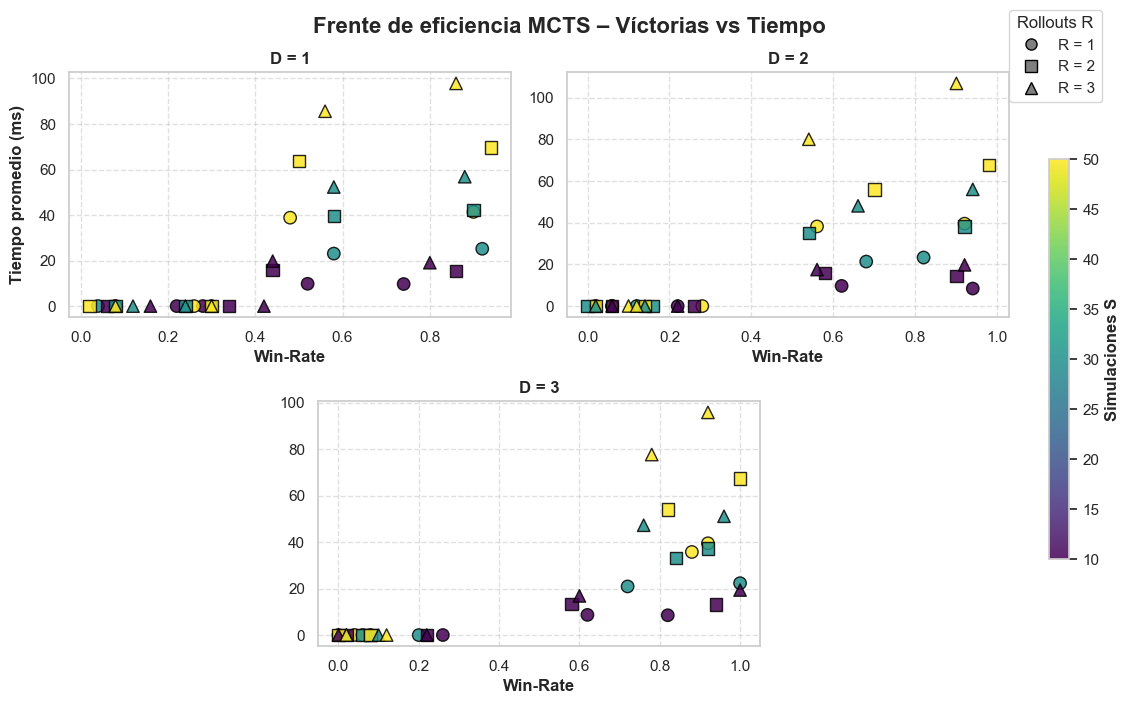

   -> Gráfico guardado en: analisis_tateti\mcts_frente_dashboard_D1_2_3.png


In [9]:
plot_frente_eficiencia_mcts_dashboard(
    df_mcts_vs_random,
    depths=[1, 2, 3],
    output_dir=OUTPUT_DIR
)


In [10]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_curvas_mcts_subplots(
        data: pd.DataFrame,
        param_x: str,            # parámetro que se pondrá en el eje X y se variará
        param_fixed: str,        # parámetro que se dejará fijo para dividir en subplots
        output_dir: str,
        figsize_each=(5, 3),     # tamaño de cada panel (ancho, alto)
        max_cols=3               # cuántos subplots como máximo por fila
    ):
    """
    Crea una cuadrícula de subplots. Cada panel corresponde a un valor distinto
    de 'param_fixed'. Dentro de cada panel se dibujan dos curvas (líneas):
      • Tiempo medio por acción  (Average Time ms)    – eje Y izquierdo
      • Victorias medias         (Total Wins medio)   – eje Y derecho
    """

    # --- 1) Filtramos solo los match-ups entre MCTS y Random
    df = data[data["matchup"].isin(["MCTS vs Random", "Random vs MCTS"])].copy()
    if df.empty:
        print("No hay datos de MCTS vs Random.")
        return

    # --- 2) Agrupamos para obtener promedios por combinación de parámetros
    agg = (df
           .groupby([param_fixed, param_x], as_index=False)
           .agg({"Average Time (ms)": "mean", "Total Wins": "mean"}))

    # --- 3) Valores únicos del parámetro fijo → n subplots
    fixed_values = sorted(agg[param_fixed].unique())
    n_panels = len(fixed_values)
    n_cols = min(max_cols, n_panels)
    n_rows = math.ceil(n_panels / n_cols)

    # Tamaño total de la figura
    fig_w = n_cols * figsize_each[0]
    fig_h = n_rows * figsize_each[1]
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(fig_w, fig_h),
                             squeeze=False)

    # --- 4) Dibujar cada panel ----------------------------------------
    for idx, fixed_val in enumerate(fixed_values):
        r, c = divmod(idx, n_cols)
        ax_time = axes[r][c]

        sub = agg[agg[param_fixed] == fixed_val]
        sub = sub.sort_values(param_x)

        # Curva 1 – Tiempo
        line1 = ax_time.plot(sub[param_x], sub["Average Time (ms)"],
                             marker="o", linewidth=2,
                             label="Average Time (ms)")

        # Curva 2 – Victorias en eje secundario
        ax_wins = ax_time.twinx()
        line2 = ax_wins.plot(sub[param_x], sub["Total Wins"],
                             marker="s", linestyle="--",
                             linewidth=2, color="C3",
                             label="Total Wins")

        # Ejes y rótulos
        ax_time.set_title(f"{param_fixed} = {fixed_val}", weight="bold")
        ax_time.set_xlabel(param_x, weight="bold")
        ax_time.set_ylabel("Tiempo (ms)")
        ax_wins.set_ylabel("Victorias")

        # Unir las leyendas solo la primera vez o si lo prefieres en cada panel
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax_time.legend(lines, labels, loc="best", fontsize=8)

        # Cuadrícula y estilo
        ax_time.grid(True, linestyle="--", alpha=0.6)
        sns.despine(ax=ax_time, right=False)

    # Elimina subplots vacíos (si n_panels < n_rows*n_cols)
    for idx in range(n_panels, n_rows * n_cols):
        r, c = divmod(idx, n_cols)
        axes[r][c].axis("off")

    # --- 5) Título y guardado -----------------------------------------
    fig.suptitle(f"MCTS vs Random – {param_x} en función de {param_fixed}",
                 fontsize=16, weight="bold", y=0.99)
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    os.makedirs(output_dir, exist_ok=True)
    out_path = os.path.join(output_dir,
                            f"mcts_curvas_{param_x}_por_{param_fixed}.png")
    plt.savefig(out_path, dpi=300)
    plt.show()
    print(f"   -> Gráfico guardado en: {out_path}")


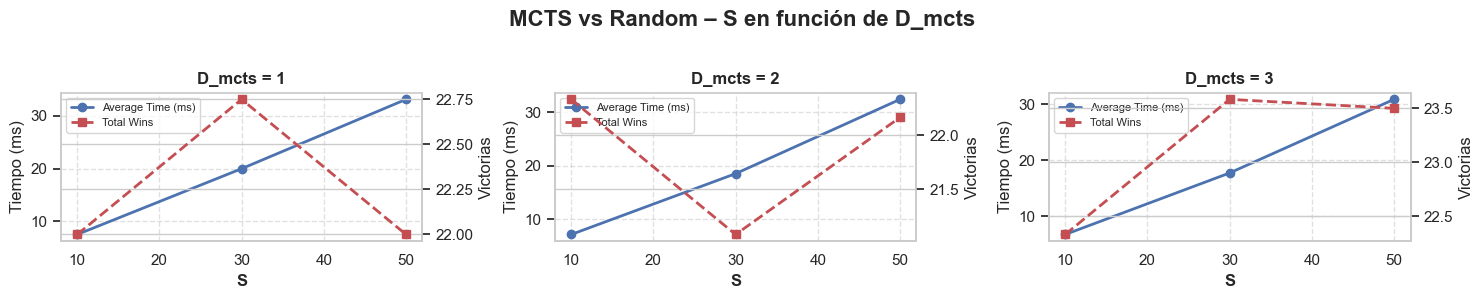

   -> Gráfico guardado en: analisis_tateti\mcts_curvas_S_por_D_mcts.png


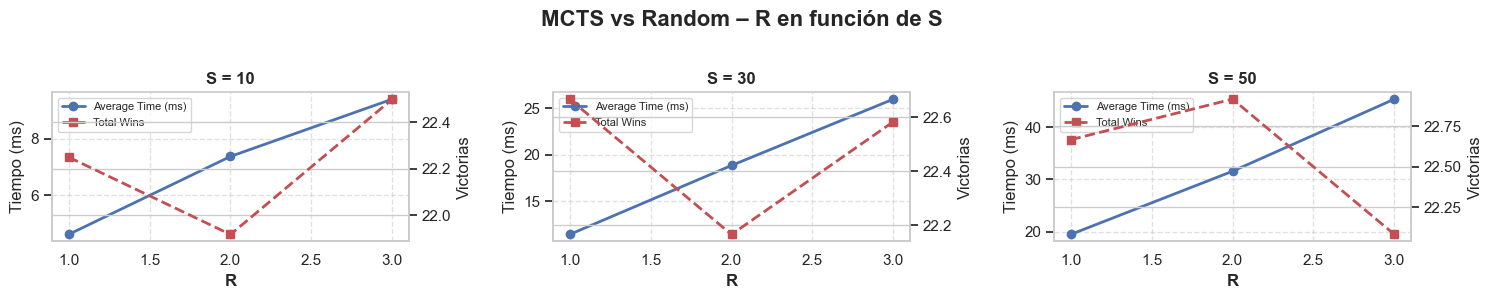

   -> Gráfico guardado en: analisis_tateti\mcts_curvas_R_por_S.png


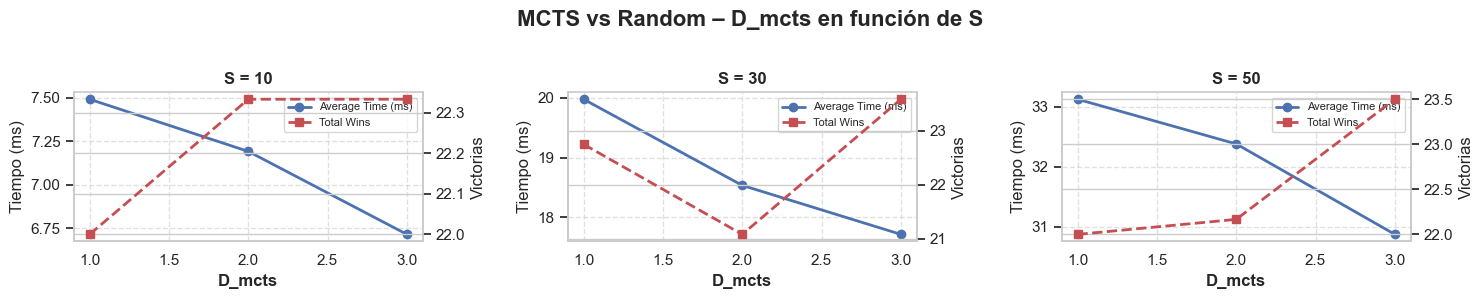

   -> Gráfico guardado en: analisis_tateti\mcts_curvas_D_mcts_por_S.png


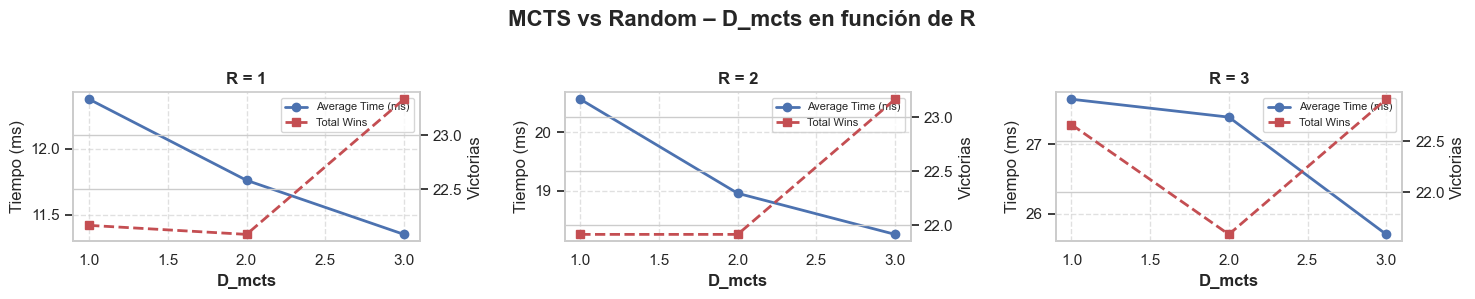

   -> Gráfico guardado en: analisis_tateti\mcts_curvas_D_mcts_por_R.png


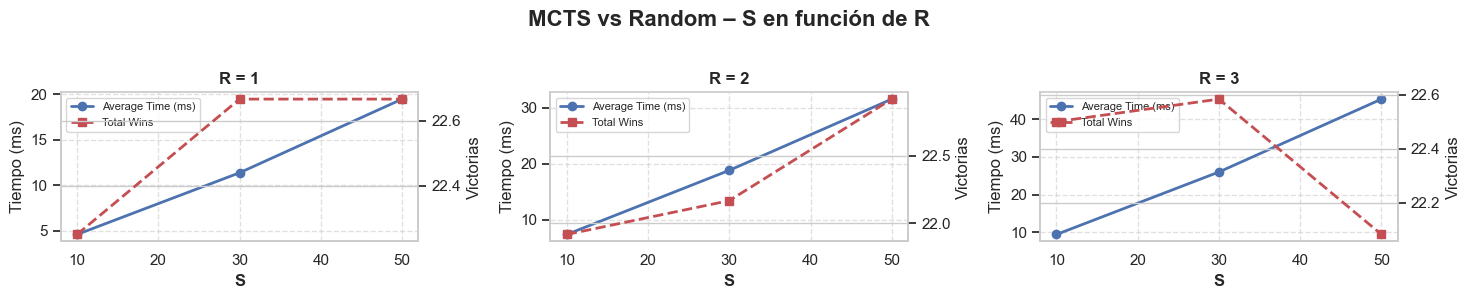

   -> Gráfico guardado en: analisis_tateti\mcts_curvas_S_por_R.png


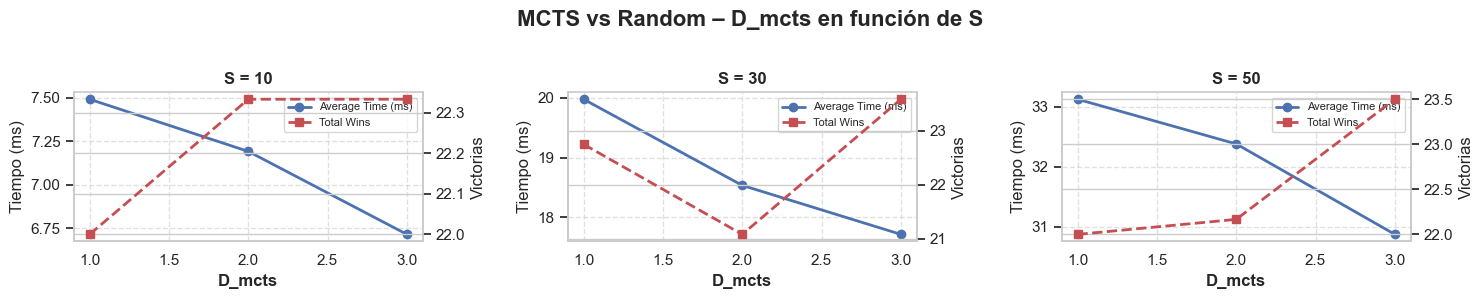

   -> Gráfico guardado en: analisis_tateti\mcts_curvas_D_mcts_por_S.png


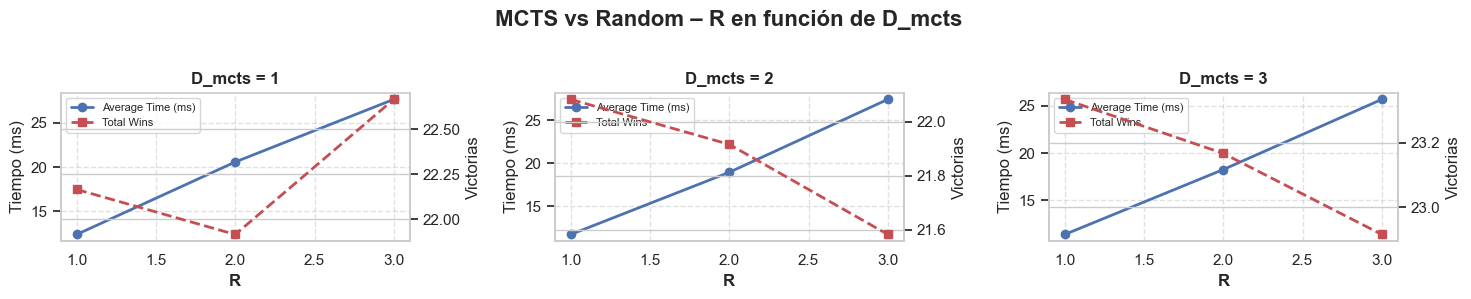

   -> Gráfico guardado en: analisis_tateti\mcts_curvas_R_por_D_mcts.png


In [25]:
# 1) Barrer S, un panel por cada profundidad D
plot_curvas_mcts_subplots(df_mcts_vs_random,
                          param_x="S",
                          param_fixed="D_mcts",
                          output_dir=OUTPUT_DIR)

# 2) Barrer R, un panel por cada S
plot_curvas_mcts_subplots(df_mcts_vs_random,
                          param_x="R",
                          param_fixed="S",
                          output_dir=OUTPUT_DIR,
                          max_cols=4)          # ajusta columnas si son muchos S

plot_curvas_mcts_subplots(df_mcts_vs_random,
                            param_x="D_mcts",
                            param_fixed="S",
                            output_dir=OUTPUT_DIR,
                            max_cols=4)          # ajusta columnas si son muchos S

# 3) Barrer D_mcts, un panel por cada S
plot_curvas_mcts_subplots(df_mcts_vs_random,
                          param_x="D_mcts",
                          param_fixed="R",
                          output_dir=OUTPUT_DIR,
                          max_cols=4)          # ajusta columnas si son muchos S

plot_curvas_mcts_subplots(df_mcts_vs_random,
                          param_x="S",
                            param_fixed="R",
                            output_dir=OUTPUT_DIR,
                            max_cols=4)          # ajusta columnas si son muchos S

# 4) Barrer D_mcts, un panel por cada R
plot_curvas_mcts_subplots(df_mcts_vs_random,
                          param_x="D_mcts",
                          param_fixed="S",
                          output_dir=OUTPUT_DIR,
                          max_cols=4)          # ajusta columnas si son muchos S

plot_curvas_mcts_subplots(df_mcts_vs_random,
                          param_x="R",
                          param_fixed="D_mcts",
                          output_dir=OUTPUT_DIR,
                          max_cols=4)          # ajusta columnas si son muchos S


## MCTS vs Minimax (y viceversa)

In [29]:
df_mcts_vs_minimax = df[
    df["matchup"].isin(["MCTS vs MiniMax", "MiniMax vs MCTS"])
].copy()

# Opcional: descartar filas sin simulaciones o con D_mcts = 0, etc.
df_mcts_vs_minimax = df_mcts_vs_minimax[df_mcts_vs_minimax["S"] > 0]
#save the filtered DataFrame to a CSV file
df_mcts_vs_minimax.to_csv(os.path.join(OUTPUT_DIR, 'mcts_vs_minimax_filtered.csv'), index=False)


if df_mcts_vs_minimax.empty:
    print("No se encontraron datos para 'MCTS vs MiniMax'.")


-> Creando Dashboard de Rendimiento para: MCTS (X) vs. MiniMax (O)


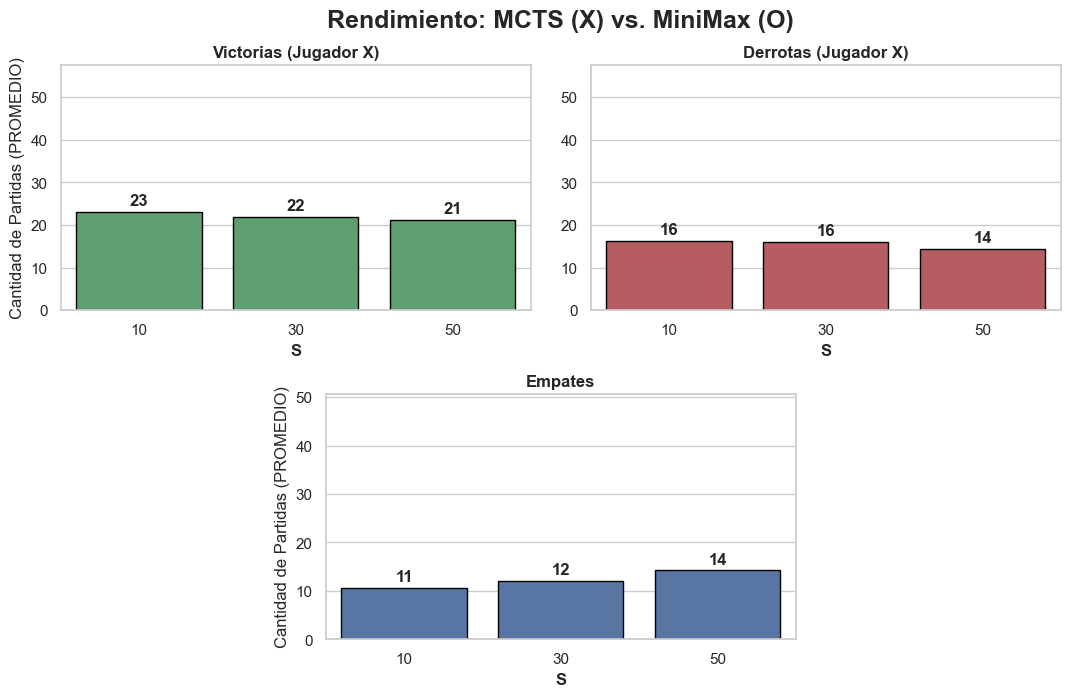

   -> Dashboard guardado en: analisis_tateti\dashboard_MCTS_vs_MiniMax.png
-> Creando Dashboard de Rendimiento para: MCTS (X) vs. MiniMax (O)


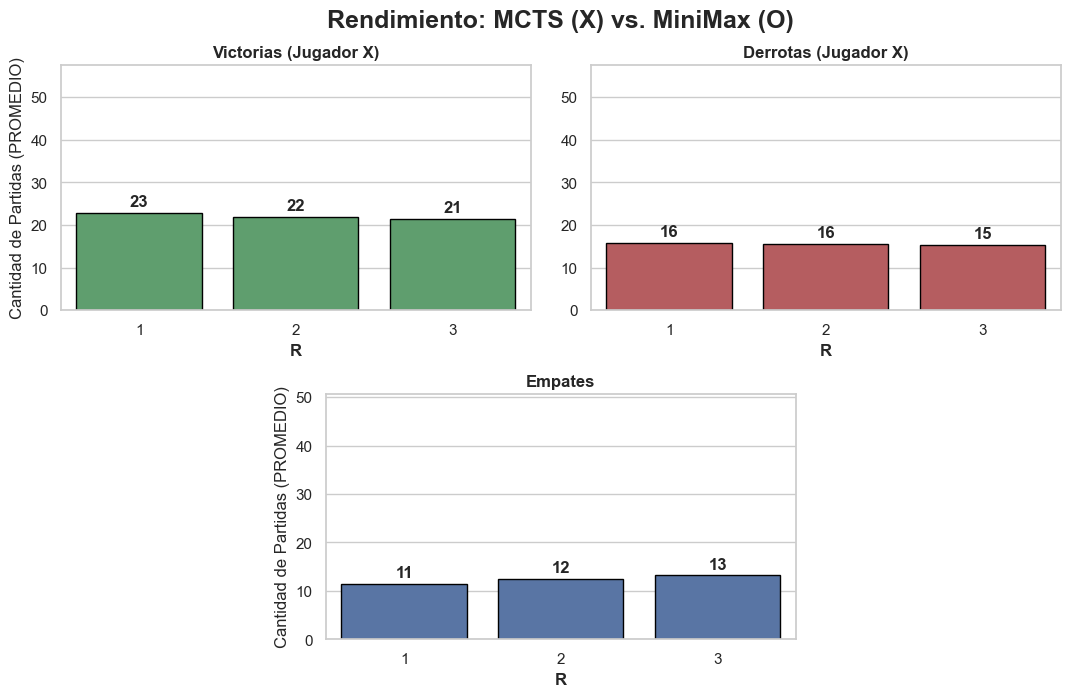

   -> Dashboard guardado en: analisis_tateti\dashboard_MCTS_vs_MiniMax.png
-> Creando Dashboard de Rendimiento para: MCTS (X) vs. MiniMax (O)


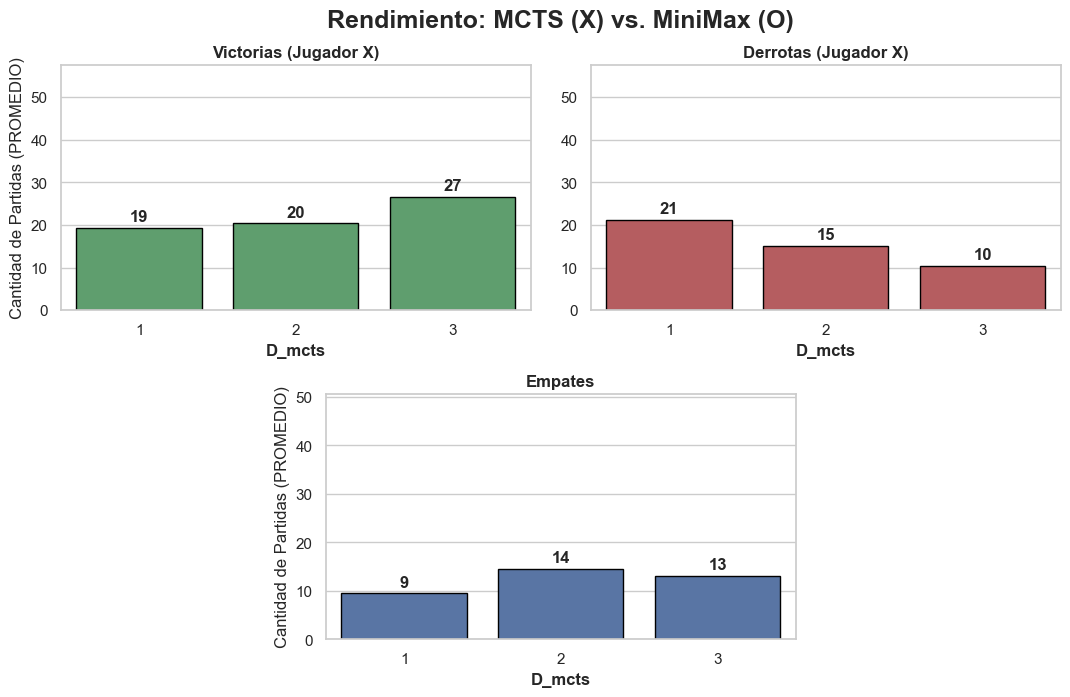

   -> Dashboard guardado en: analisis_tateti\dashboard_MCTS_vs_MiniMax.png
-> Creando Dashboard de Rendimiento para: MiniMax (X) vs. MCTS (O)


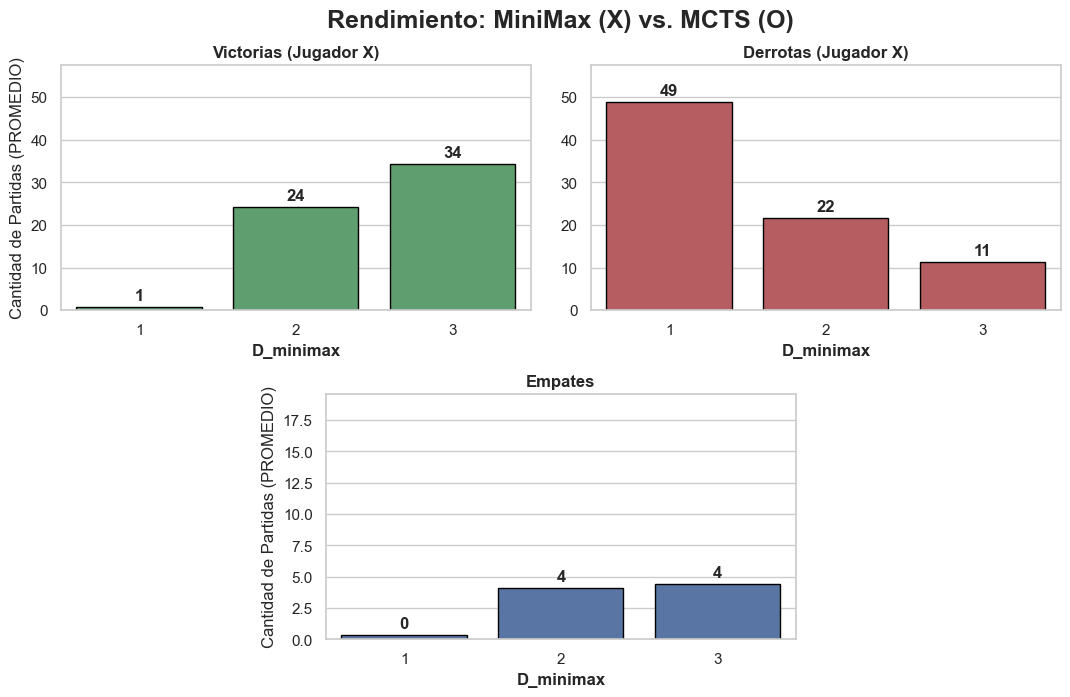

   -> Dashboard guardado en: analisis_tateti\dashboard_MiniMax_vs_MCTS.png


In [30]:
# A) MCTS como Jugador X
plot_dashboard_rendimiento(
    df,
    agent_x_name="MCTS",
    opponent_name="MiniMax",
    param_col="S",          # o R / D_mcts
    output_dir=OUTPUT_DIR
)

plot_dashboard_rendimiento(
    df,
    agent_x_name="MCTS",
    opponent_name="MiniMax",
    param_col="R",          # o R / D_mcts
    output_dir=OUTPUT_DIR
)

plot_dashboard_rendimiento(
    df,
    agent_x_name="MCTS",
    opponent_name="MiniMax",
    param_col="D_mcts",          # o R / D_mcts
    output_dir=OUTPUT_DIR
)

# B) MiniMax como Jugador X
plot_dashboard_rendimiento(
    df,
    agent_x_name="MiniMax",
    opponent_name="MCTS",
    param_col="D_minimax",  # profundidades de MiniMax
    output_dir=OUTPUT_DIR
)


-> Gráfico 2: Coste computacional de MCTS + victorias…


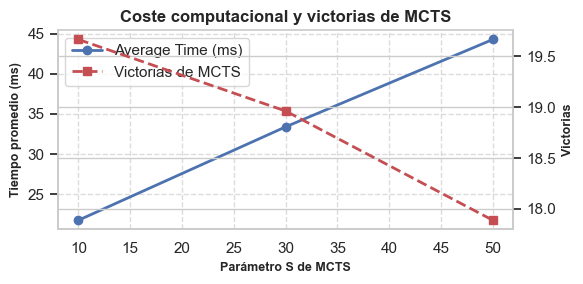

   -> Gráfico guardado en: analisis_tateti\mcts_coste_vs_S.png
-> Gráfico 2: Coste computacional de MCTS + victorias…


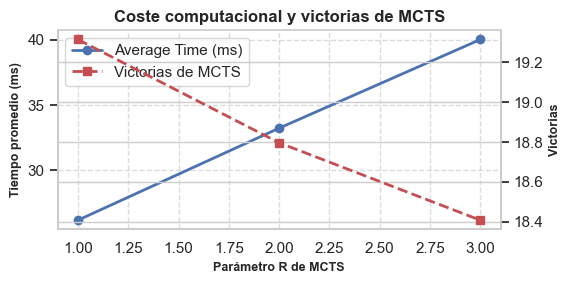

   -> Gráfico guardado en: analisis_tateti\mcts_coste_vs_R.png
-> Gráfico 2: Coste computacional de MCTS + victorias…


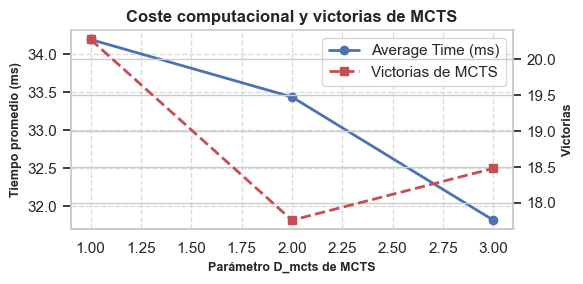

   -> Gráfico guardado en: analisis_tateti\mcts_coste_vs_D_mcts.png


In [14]:
plot_coste_mcts(
    df_mcts_vs_minimax[df_mcts_vs_minimax["agent_1_type"] == "MCTS"],
    param_col="S",
    output_dir=OUTPUT_DIR
)

plot_coste_mcts(
    df_mcts_vs_minimax[df_mcts_vs_minimax["agent_1_type"] == "MCTS"],
    param_col="R",
    output_dir=OUTPUT_DIR
)

plot_coste_mcts(
    df_mcts_vs_minimax[df_mcts_vs_minimax["agent_1_type"] == "MCTS"],
    param_col="D_mcts",
    output_dir=OUTPUT_DIR
)


-> Gráfico: Comparando rendimiento de MCTS como Jugador X vs. O frente a MiniMax…


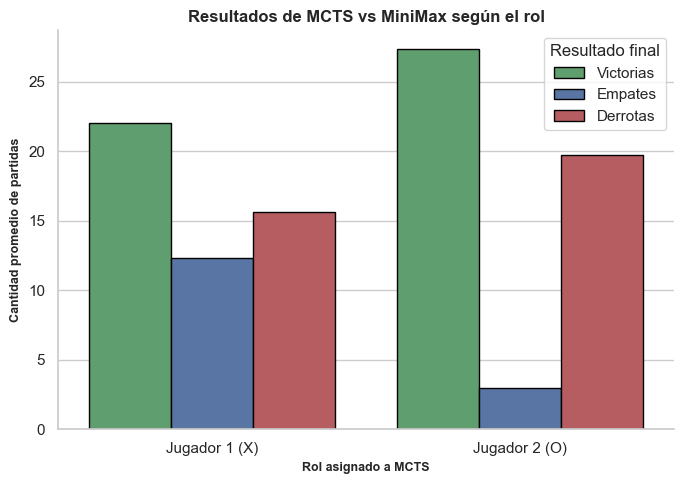

   -> Gráfico guardado en: analisis_tateti\mcts_minimax_comparacion_roles.png


In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_comparacion_roles_mcts_minimax(data: pd.DataFrame, output_dir: str):
    """
    Compara el rendimiento de **MCTS** cuando juega primero (X) vs. segundo (O)
    contra MiniMax, con el mismo estilo usado en la función de MiniMax vs Random.
    """
    print("-> Gráfico: Comparando rendimiento de MCTS como Jugador X vs. O frente a MiniMax…")

    resumen = []

    # ── Caso 1 · MCTS es Jugador X ────────────────────────────────
    subset_x = data[data["matchup"] == "MCTS vs MiniMax"]
    if not subset_x.empty:
        wins   = subset_x[subset_x["Agent Role"] == "X"]["Total Wins"  ].mean()
        draws  = subset_x[subset_x["Agent Role"] == "X"]["Total Draws" ].mean()
        losses = subset_x[subset_x["Agent Role"] == "X"]["Total Losses"].mean()
        resumen += [
            {"Rol de MCTS": "Jugador 1 (X)", "Resultado": "Victorias", "Cantidad": wins},
            {"Rol de MCTS": "Jugador 1 (X)", "Resultado": "Empates",   "Cantidad": draws},
            {"Rol de MCTS": "Jugador 1 (X)", "Resultado": "Derrotas",  "Cantidad": losses},
        ]

    # ── Caso 2 · MCTS es Jugador O ────────────────────────────────
    subset_o = data[data["matchup"] == "MiniMax vs MCTS"]
    if not subset_o.empty:
        # Ahora las victorias de MCTS son las derrotas del Agente X (MiniMax)
        wins   = subset_o[subset_o["Agent Role"] == "X"]["Total Losses"].mean()
        draws  = subset_o[subset_o["Agent Role"] == "X"]["Total Draws" ].mean()
        losses = subset_o[subset_o["Agent Role"] == "X"]["Total Wins"  ].mean()
        resumen += [
            {"Rol de MCTS": "Jugador 2 (O)", "Resultado": "Victorias", "Cantidad": wins},
            {"Rol de MCTS": "Jugador 2 (O)", "Resultado": "Empates",   "Cantidad": draws},
            {"Rol de MCTS": "Jugador 2 (O)", "Resultado": "Derrotas",  "Cantidad": losses},
        ]

    if not resumen:
        print("   -> No hay datos suficientes para la comparación de roles.")
        return

    resumen_df = pd.DataFrame(resumen)

    # ── Plot ──────────────────────────────────────────────────────
    plt.figure(figsize=(7, 5))
    sns.barplot(
        data=resumen_df,
        x="Rol de MCTS",
        y="Cantidad",
        hue="Resultado",
        edgecolor="black",
        palette=["C2", "C0", "C3"]    # Verde, Azul, Rojo
    )

    plt.title("Resultados de MCTS vs MiniMax según el rol", fontsize=12, weight="bold")
    plt.xlabel("Rol asignado a MCTS", fontsize=9, weight="bold")
    plt.ylabel("Cantidad promedio de partidas", fontsize=9, weight="bold")
    plt.legend(title="Resultado final")
    sns.despine()
    plt.tight_layout()

    os.makedirs(output_dir, exist_ok=True)
    out_path = os.path.join(output_dir, "mcts_minimax_comparacion_roles.png")
    plt.savefig(out_path, dpi=300)
    plt.show()
    print(f"   -> Gráfico guardado en: {out_path}")


plot_comparacion_roles_mcts_minimax(df_mcts_vs_minimax, OUTPUT_DIR)


In [31]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_frente_eficiencia_mcts_dashboard_minimax(
        data: pd.DataFrame,
        depths: list[int],           # EXACTAMENTE tres valores, ej. [1,2,3] o [3,4,5]
        output_dir: str,
        figsize=(10, 7)
    ):
    """
    Frente de eficiencia (Win-Rate vs Average Time) para MCTS contra MiniMax,
    con el clásico layout 2-arriba / 1-abajo centrado:

        ┌─────────────┬─────────────┐
        │  D = d₁     │  D = d₂     │
        └─────────────┴─────────────┐
                   D = d₃           │
        └───────────────────────────┘

    • X  – Win-Rate
    • Y  – Average Time (ms)
    • Color  – S  (nº de simulaciones)
    • Marker – R  (nº de rollouts)
    """

    # 1) Filtrar MCTS ↔ MiniMax
    df = data[data["matchup"].isin(["MCTS vs MiniMax", "MiniMax vs MCTS"])].copy()
    if df.empty:
        print("No hay datos de MCTS vs MiniMax.")
        return

    df["WinRate"] = df["Total Wins"] / df["Total Games"]

    # 2) Crear mapa de markers para cada R
    marker_cycle = itertools.cycle(["o", "s", "^", "D", "P", "X", "v", "*"])
    marker_map = {r: m for r, m in zip(sorted(df["R"].unique()), marker_cycle)}

    # 3) Figura y ejes “a mano” (2+1 layout)
    fig = plt.figure(figsize=figsize)
    ax_pos = {
        0: [0.00, 0.55, 0.47, 0.35],   # arriba-izq
        1: [0.53, 0.55, 0.47, 0.35],   # arriba-der
        2: [0.265, 0.08, 0.47, 0.35]   # abajo-centro
    }
    axes = []

    for i, D in enumerate(depths):
        ax = fig.add_axes(ax_pos[i])
        axes.append(ax)

        sub = df[df["D_mcts"] == D]
        if sub.empty:
            ax.text(0.5, 0.5, f"Sin datos\nD = {D}",
                    ha="center", va="center", fontsize=10)
            ax.axis("off")
            continue

        # Puntos: agrupar por R para cambiar de marker
        for r_val, grp in sub.groupby("R"):
            ax.scatter(grp["WinRate"], grp["Average Time (ms)"],
                       c=grp["S"], cmap="viridis",
                       marker=marker_map[r_val],
                       edgecolor="black", alpha=0.85, s=80,
                       label=f"R = {r_val}")

        ax.set_title(f"D = {D}", weight="bold")
        ax.set_xlabel("Win-Rate", weight="bold")
        if i == 0:
            ax.set_ylabel("Tiempo promedio (ms)", weight="bold")
        ax.grid(True, ls="--", alpha=0.6)

    # 4) Colorbar global (fuera de los ejes de datos)
    first_coll = next(ax.collections[0] for ax in axes if ax.collections)
    cbar = fig.colorbar(first_coll, ax=axes,
                        fraction=0.02, pad=0.04)
    cbar.set_label("Simulaciones S", weight="bold")

    # 5) Leyenda global de markers (R)
    handles = [plt.Line2D([], [], marker=marker_map[r], linestyle="",
                          markersize=8, markeredgecolor="black",
                          markerfacecolor="gray", label=f"R = {r}")
               for r in sorted(marker_map)]
    fig.legend(handles=handles, title="Rollouts R",
               loc="upper right", bbox_to_anchor=(1.04, 1), frameon=True)

    # 6) Título y guardado
    fig.suptitle("Frente de eficiencia • MCTS vs MiniMax",
                 fontsize=16, weight="bold", y=0.98)
    plt.tight_layout(rect=[0, 0, 0.98, 0.94])

    os.makedirs(output_dir, exist_ok=True)
    fname = "_".join(map(str, depths))
    out_path = os.path.join(output_dir,
                            f"mcts_minimax_frente_D{fname}.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"→ Gráfico guardado en: {out_path}")


C:\Users\kidni\AppData\Local\Temp\ipykernel_27324\621039728.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.98, 0.94])


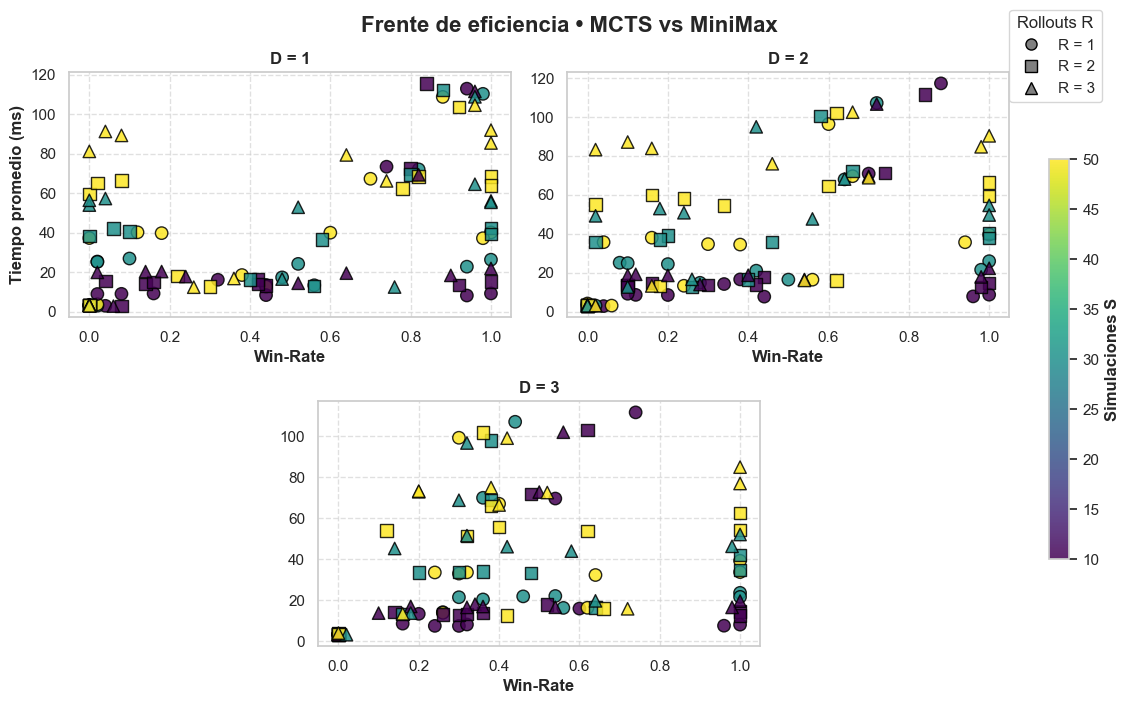

→ Gráfico guardado en: analisis_tateti\mcts_minimax_frente_D1_2_3.png


In [32]:
# Para Random
plot_frente_eficiencia_mcts_dashboard_minimax(
    df_mcts_vs_minimax, depths=[1, 2, 3],
    output_dir=OUTPUT_DIR)


In [33]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_curvas_mcts_minimax_subplots(
        data: pd.DataFrame,
        param_x: str,            # parámetro a variar en eje X
        param_fixed: str,        # parámetro fijo para dividir en subplots
        output_dir: str,
        figsize_each=(5, 3),     # tamaño de cada subplot
        max_cols=3               # max columnas por fila
    ):
    """
    Igual que plot_curvas_mcts_subplots pero para MCTS vs MiniMax.
    Dibuja dos curvas en cada panel (param_x vs Tiempo medio y Victorias medias),
    creando un panel por cada valor distinto de param_fixed.
    """

    # --- 1) Filtrar MCTS vs MiniMax en ambos sentidos
    matchups = ["MCTS vs MiniMax", "MiniMax vs MCTS"]
    df = data[data["matchup"].isin(matchups)].copy()
    if df.empty:
        print("No hay datos de MCTS vs MiniMax.")
        return

    # --- 2) Agrupar y promediar métricas para los subplots
    agg = (df
           .groupby([param_fixed, param_x], as_index=False)
           .agg({"Average Time (ms)": "mean", "Total Wins": "mean"}))

    # --- 3) Definir configuración de la cuadrícula de subplots
    fixed_values = sorted(agg[param_fixed].unique())
    n_panels = len(fixed_values)
    n_cols = min(max_cols, n_panels)
    n_rows = math.ceil(n_panels / n_cols)

    fig_w = n_cols * figsize_each[0]
    fig_h = n_rows * figsize_each[1]
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), squeeze=False)

    # --- 4) Dibujar cada subplot ---
    for idx, fixed_val in enumerate(fixed_values):
        r, c = divmod(idx, n_cols)
        ax_time = axes[r][c]

        sub = agg[agg[param_fixed] == fixed_val]
        sub = sub.sort_values(param_x)

        # Curva 1: Tiempo medio (ms)
        line1 = ax_time.plot(sub[param_x], sub["Average Time (ms)"],
                             marker="o", linewidth=2,
                             label="Average Time (ms)")

        # Curva 2: Victorias medias (eje secundario)
        ax_wins = ax_time.twinx()
        line2 = ax_wins.plot(sub[param_x], sub["Total Wins"],
                             marker="s", linestyle="--", linewidth=2, color="C3",
                             label="Total Wins")

        # Etiquetas y estilo
        ax_time.set_title(f"{param_fixed} = {fixed_val}", weight="bold")
        ax_time.set_xlabel(param_x, weight="bold")
        ax_time.set_ylabel("Tiempo (ms)")
        ax_wins.set_ylabel("Victorias")
        ax_time.grid(True, linestyle="--", alpha=0.6)
        sns.despine(ax=ax_time, right=False)

        # Leyenda combinada
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax_time.legend(lines, labels, loc="best", fontsize=8)

    # --- 5) Quitar subplots vacíos ---
    for idx in range(n_panels, n_rows * n_cols):
        r, c = divmod(idx, n_cols)
        axes[r][c].axis("off")

    # --- 6) Título general y guardar ---
    fig.suptitle(f"MCTS vs MiniMax – {param_x} en función de {param_fixed}",
                 fontsize=16, weight="bold", y=0.99)
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    os.makedirs(output_dir, exist_ok=True)
    out_path = os.path.join(output_dir,
                            f"mcts_minimax_curvas_{param_x}_por_{param_fixed}.png")
    plt.savefig(out_path, dpi=300)
    plt.show()
    print(f"   -> Gráfico guardado en: {out_path}")


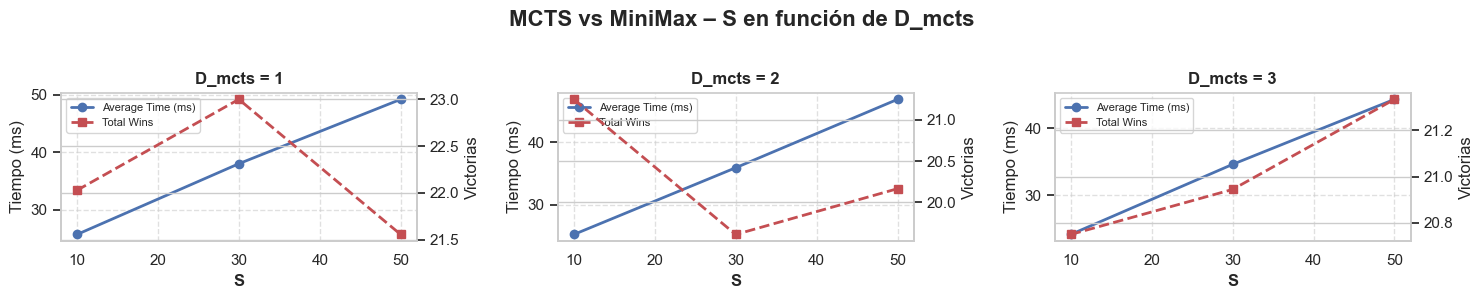

   -> Gráfico guardado en: analisis_tateti\mcts_minimax_curvas_S_por_D_mcts.png


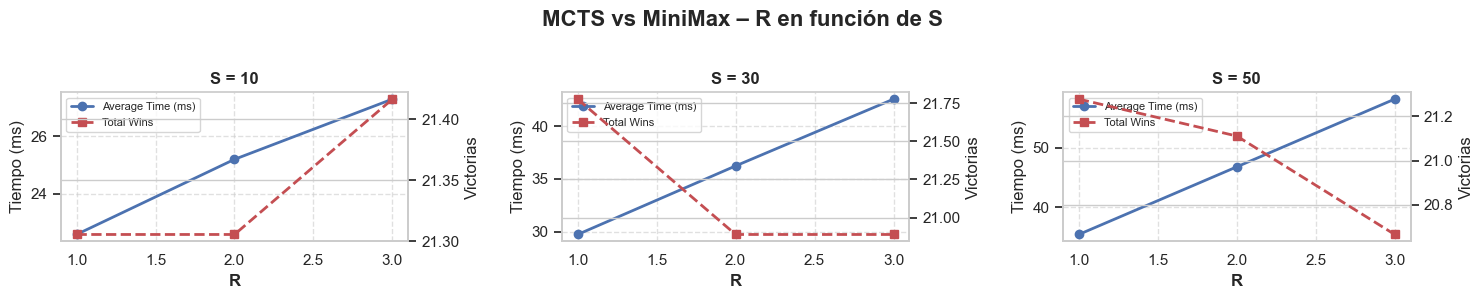

   -> Gráfico guardado en: analisis_tateti\mcts_minimax_curvas_R_por_S.png


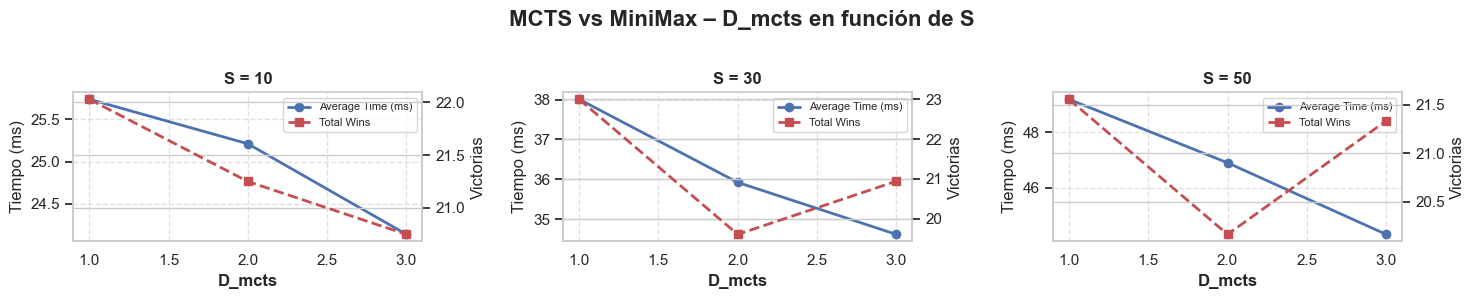

   -> Gráfico guardado en: analisis_tateti\mcts_minimax_curvas_D_mcts_por_S.png


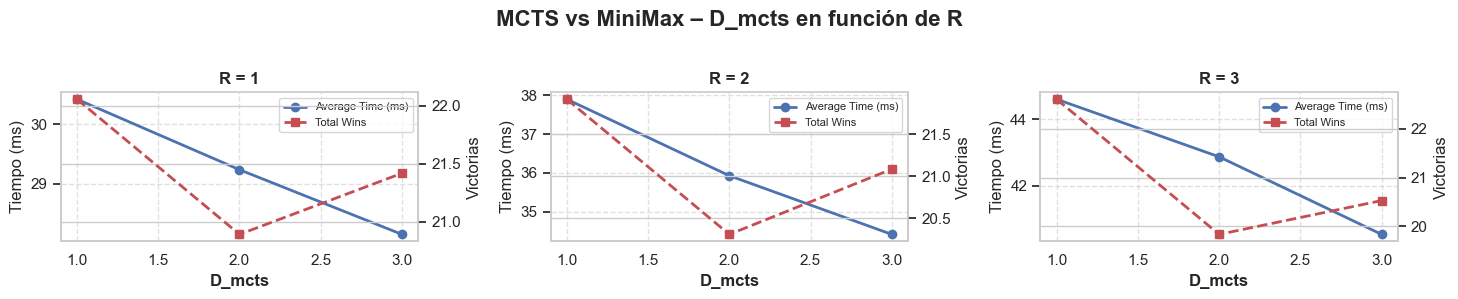

   -> Gráfico guardado en: analisis_tateti\mcts_minimax_curvas_D_mcts_por_R.png


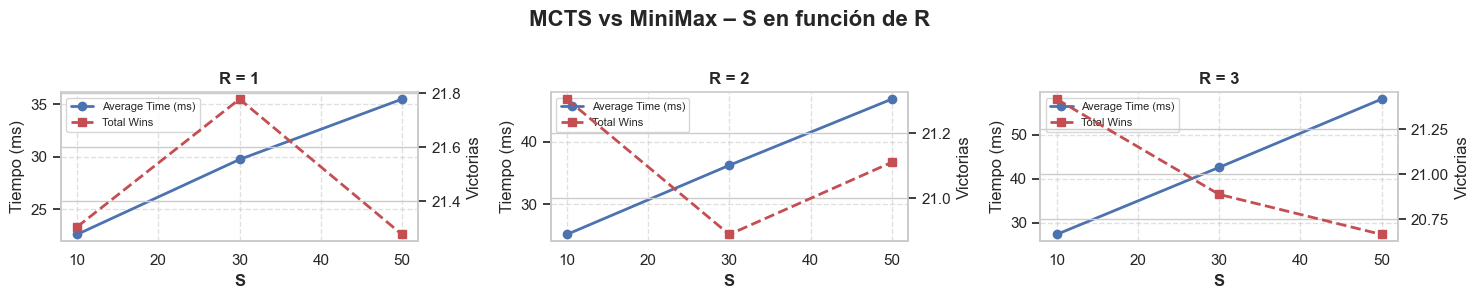

   -> Gráfico guardado en: analisis_tateti\mcts_minimax_curvas_S_por_R.png


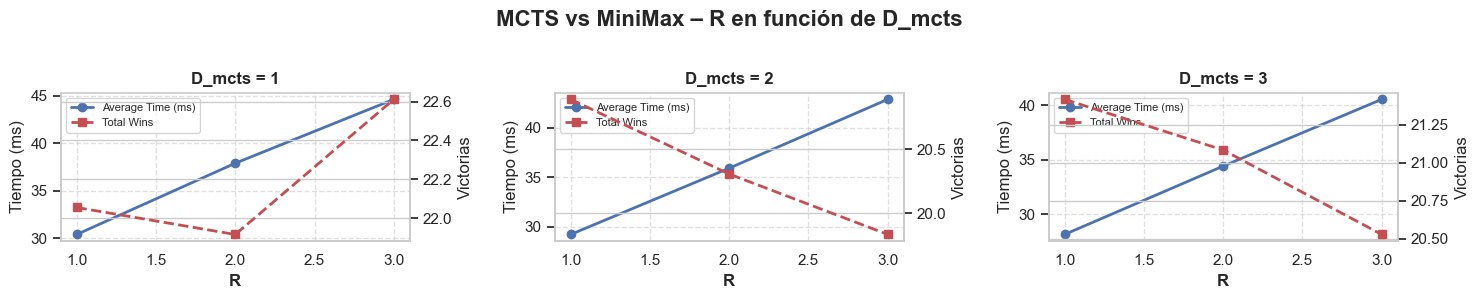

   -> Gráfico guardado en: analisis_tateti\mcts_minimax_curvas_R_por_D_mcts.png


In [34]:
# 1) Barrer S, un panel por cada profundidad D_mcts
plot_curvas_mcts_minimax_subplots(df_mcts_vs_minimax,
                                  param_x="S",
                                  param_fixed="D_mcts",
                                  output_dir=OUTPUT_DIR)

# 2) Barrer R, un panel por cada S
plot_curvas_mcts_minimax_subplots(df_mcts_vs_minimax,
                                  param_x="R",
                                  param_fixed="S",
                                  output_dir=OUTPUT_DIR,
                                  max_cols=4)

# 3) Barrer D_mcts, un panel por cada S
plot_curvas_mcts_minimax_subplots(df_mcts_vs_minimax,
                                  param_x="D_mcts",
                                  param_fixed="S",
                                  output_dir=OUTPUT_DIR,
                                  max_cols=4)

# 4) Barrer D_mcts, un panel por cada R
plot_curvas_mcts_minimax_subplots(df_mcts_vs_minimax,
                                  param_x="D_mcts",
                                  param_fixed="R",
                                  output_dir=OUTPUT_DIR,
                                  max_cols=4)

plot_curvas_mcts_minimax_subplots(df_mcts_vs_minimax,
                                    param_x="S",
                                    param_fixed="R",
                                    output_dir=OUTPUT_DIR,
                                    max_cols=4)

plot_curvas_mcts_minimax_subplots(df_mcts_vs_minimax,
                                  param_x="R",
                                  param_fixed="D_mcts",
                                  output_dir=OUTPUT_DIR,
                                  max_cols=4)


## MCTS vs MCTS

In [20]:
df_mcts_vs_mcts = df[df["matchup"] == "MCTS vs MCTS"].copy()

# si hay partidas donde S = 0 o D_mcts = 0, las descartamos
df_mcts_vs_mcts = df_mcts_vs_mcts[df_mcts_vs_mcts["S"] > 0]

#save the filtered DataFrame to a CSV file
df_mcts_vs_mcts.to_csv(os.path.join(OUTPUT_DIR, 'mcts_vs_mcts_filtered.csv'), index=False)

if df_mcts_vs_mcts.empty:
    print("No se encontraron filas con 'MCTS vs MCTS'.")


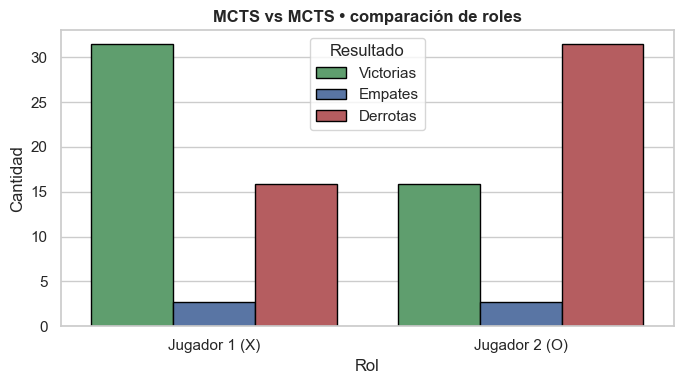

→ Guardado en analisis_tateti\mcts_vs_mcts_roles.png


In [21]:
def plot_comparacion_roles_mcts_mirror(data: pd.DataFrame, output_dir: str):
    resumen = []

    # X vs X  (MCTS es Jugador X y Jugador O en la misma partida; usamos promedios)
    wins_x   = data[data["Agent Role"] == "X"]["Total Wins"  ].mean()
    draws_x  = data[data["Agent Role"] == "X"]["Total Draws" ].mean()
    losses_x = data[data["Agent Role"] == "X"]["Total Losses"].mean()

    wins_o   = data[data["Agent Role"] == "X"]["Total Losses"].mean()
    draws_o  = data[data["Agent Role"] == "X"]["Total Draws" ].mean()
    losses_o = data[data["Agent Role"] == "X"]["Total Wins"  ].mean()

    resumen += [
        {"Rol": "Jugador 1 (X)", "Resultado": "Victorias", "Cantidad": wins_x},
        {"Rol": "Jugador 1 (X)", "Resultado": "Empates",   "Cantidad": draws_x},
        {"Rol": "Jugador 1 (X)", "Resultado": "Derrotas",  "Cantidad": losses_x},
        {"Rol": "Jugador 2 (O)", "Resultado": "Victorias", "Cantidad": wins_o},
        {"Rol": "Jugador 2 (O)", "Resultado": "Empates",   "Cantidad": draws_o},
        {"Rol": "Jugador 2 (O)", "Resultado": "Derrotas",  "Cantidad": losses_o},
    ]

    resumen_df = pd.DataFrame(resumen)
    plt.figure(figsize=(7,4))
    sns.barplot(data=resumen_df, x="Rol", y="Cantidad", hue="Resultado",
                palette=["C2","C0","C3"], edgecolor="black")
    plt.title("MCTS vs MCTS • comparación de roles", weight="bold")
    plt.tight_layout()
    os.makedirs(output_dir, exist_ok=True)
    path = os.path.join(output_dir, "mcts_vs_mcts_roles.png")
    plt.savefig(path, dpi=300); plt.show()
    print("→ Guardado en", path)


plot_comparacion_roles_mcts_mirror(df_mcts_vs_mcts, OUTPUT_DIR)

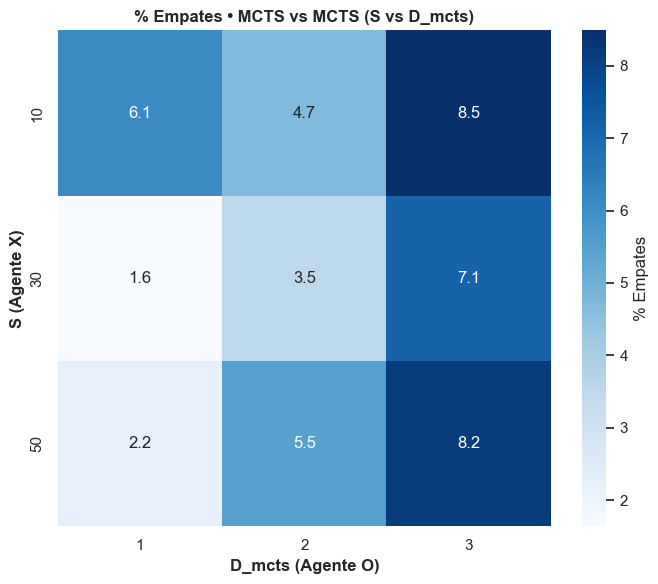

→ Guardado en analisis_tateti\heatmap_empates_S_vs_D_mcts.png


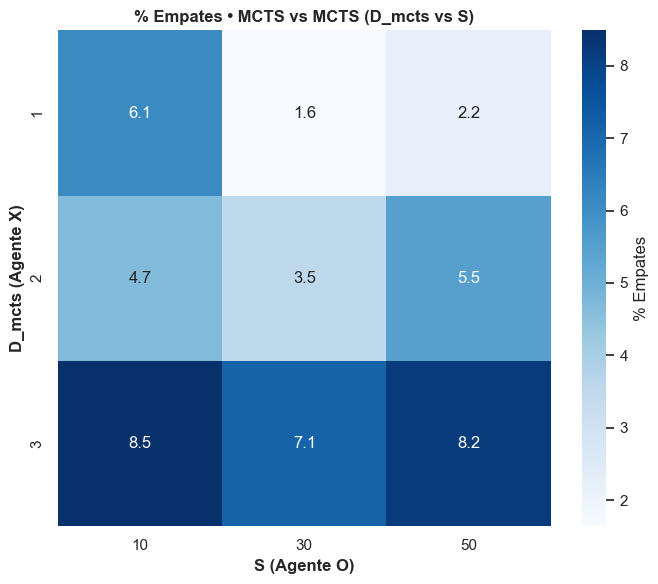

→ Guardado en analisis_tateti\heatmap_empates_D_mcts_vs_S.png


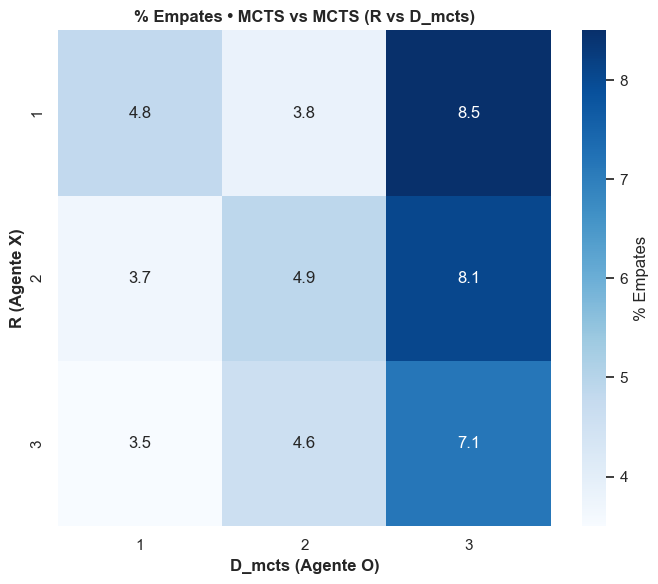

→ Guardado en analisis_tateti\heatmap_empates_R_vs_D_mcts.png


In [22]:
def plot_heatmap_empates_mcts_vs_mcts(data: pd.DataFrame, param1: str, param2: str, output_dir: str):
    df = data.copy()
    df["Empate (%)"] = df["Total Draws"] / df["Total Games"] * 100

    pivot = df.pivot_table(index=param1, columns=param2, values="Empate (%)", aggfunc="mean")

    plt.figure(figsize=(7, 6))
    sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Blues", cbar_kws={"label": "% Empates"})
    plt.title(f"% Empates • MCTS vs MCTS ({param1} vs {param2})", weight="bold")
    plt.xlabel(f"{param2} (Agente O)", weight="bold")
    plt.ylabel(f"{param1} (Agente X)", weight="bold")
    plt.tight_layout()

    os.makedirs(output_dir, exist_ok=True)
    path = os.path.join(output_dir, f"heatmap_empates_{param1}_vs_{param2}.png")
    plt.savefig(path, dpi=300)
    plt.show()
    print("→ Guardado en", path)


# Gráfico de empates por S y D_mcts
plot_heatmap_empates_mcts_vs_mcts(df_mcts_vs_mcts, param1
="S", param2="D_mcts", output_dir=OUTPUT_DIR)
plot_heatmap_empates_mcts_vs_mcts(df_mcts_vs_mcts, param1="D_mcts", param2="S", output_dir=OUTPUT_DIR)
plot_heatmap_empates_mcts_vs_mcts(df_mcts_vs_mcts, param1="R", param2="D_mcts", output_dir=OUTPUT_DIR)



C:\Users\kidni\AppData\Local\Temp\ipykernel_27324\3711108486.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.98, 0.94])


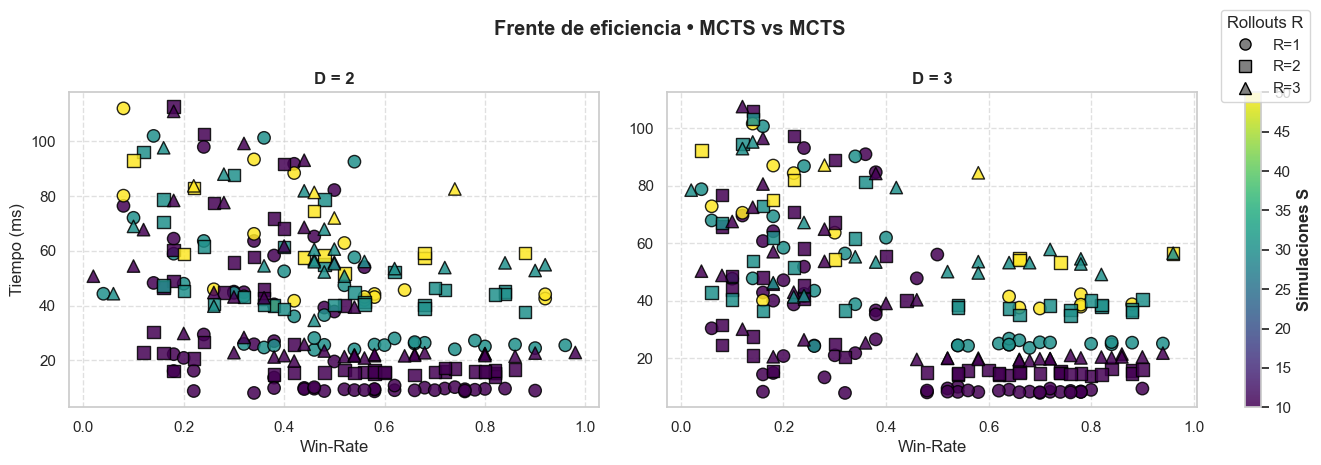

→ Guardado en analisis_tateti\mcts_mirror_frente_D2_3.png


In [36]:
def plot_frente_eficiencia_mcts_mirror(
        data: pd.DataFrame,
        depths: list[int] | None,   # e.g. [1,2,3]  (None = todas)
        output_dir: str,
        figsize=(12, 9)
    ):
    df = data.copy()
    df["WinRate"] = df["Total Wins"] / df["Total Games"]

    if depths is None:
        depths = sorted(df["D_mcts"].unique())

    marker_cycle = ["o", "s", "^", "D", "P", "*", "X"]
    marker_map = {r: marker_cycle[i % len(marker_cycle)]
                  for i, r in enumerate(sorted(df["R"].unique()))}

    # layout 2 arriba + 1 abajo
    pos = {0: [0.00, 0.55, 0.47, 0.35],
           1: [0.53, 0.55, 0.47, 0.35],
           2: [0.265, 0.08, 0.47, 0.35]}

    fig = plt.figure(figsize=figsize)
    axes = []

    for i, D in enumerate(depths):
        ax = fig.add_axes(pos[i]); axes.append(ax)
        sub = df[df["D_mcts"] == D]

        for r, g in sub.groupby("R"):
            ax.scatter(g["WinRate"], g["Average Time (ms)"],
                       c=g["S"], cmap="viridis",
                       marker=marker_map[r], edgecolor="black",
                       s=80, alpha=0.85, label=f"R={r}")

        ax.set_title(f"D = {D}", weight="bold")
        ax.set_xlabel("Win-Rate")
        if i == 0:
            ax.set_ylabel("Tiempo (ms)")
        ax.grid(True, ls="--", alpha=0.6)

    # colorbar
    ref = axes[0].collections[0]
    cbar = fig.colorbar(ref, ax=axes, fraction=0.02, pad=0.04)
    cbar.set_label("Simulaciones S", weight="bold")

    # leyenda global de R
    handles = [plt.Line2D([], [], marker=marker_map[r], ls="",
                          ms=8, mec="black", mfc="gray", label=f"R={r}")
               for r in sorted(marker_map)]
    fig.legend(handles=handles, title="Rollouts R",
               loc="upper right", bbox_to_anchor=(1.04, 1), frameon=True)

    fig.suptitle("Frente de eficiencia • MCTS vs MCTS", weight="bold")
    plt.tight_layout(rect=[0, 0, 0.98, 0.94])

    os.makedirs(output_dir, exist_ok=True)
    fname = "_".join(map(str, depths))
    path = os.path.join(output_dir, f"mcts_mirror_frente_D{fname}.png")
    plt.savefig(path, dpi=300); plt.show()
    print("→ Guardado en", path)

plot_frente_eficiencia_mcts_mirror(
    df_mcts_vs_mcts, depths=[2, 3],
    output_dir=OUTPUT_DIR
)

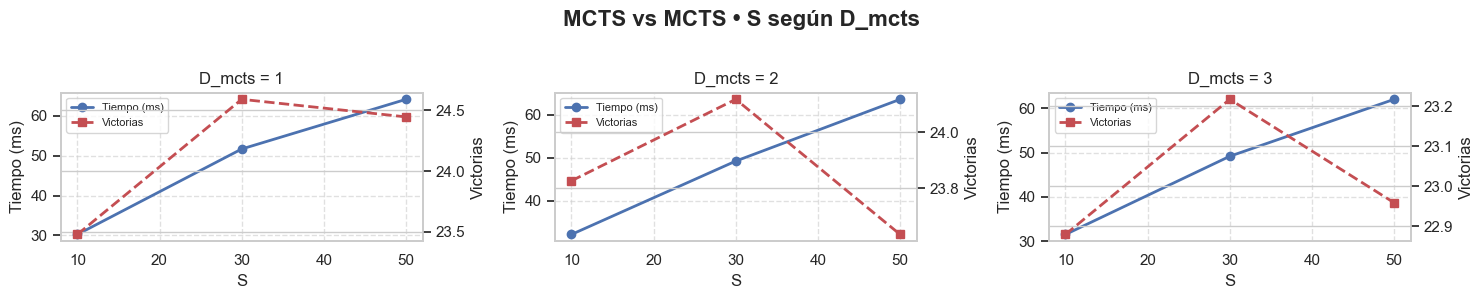

→ Guardado en analisis_tateti\curvas_mcts_vs_mcts_S_por_D_mcts.png


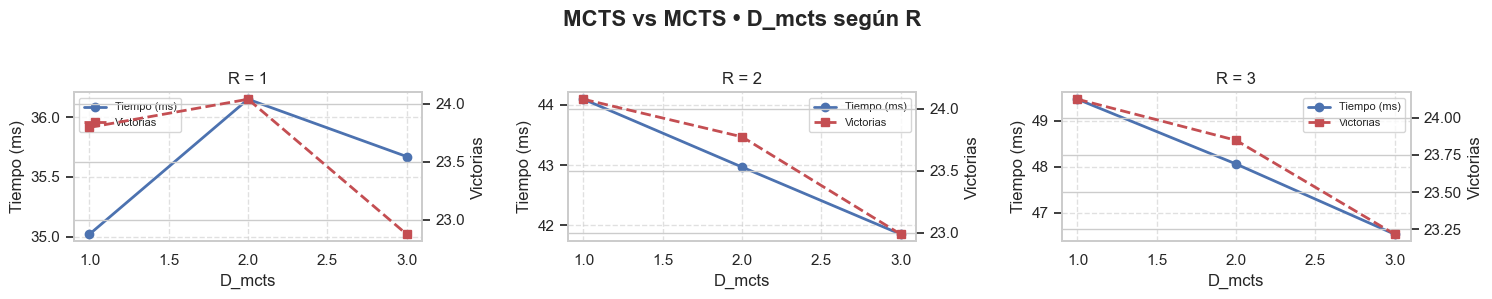

→ Guardado en analisis_tateti\curvas_mcts_vs_mcts_D_mcts_por_R.png


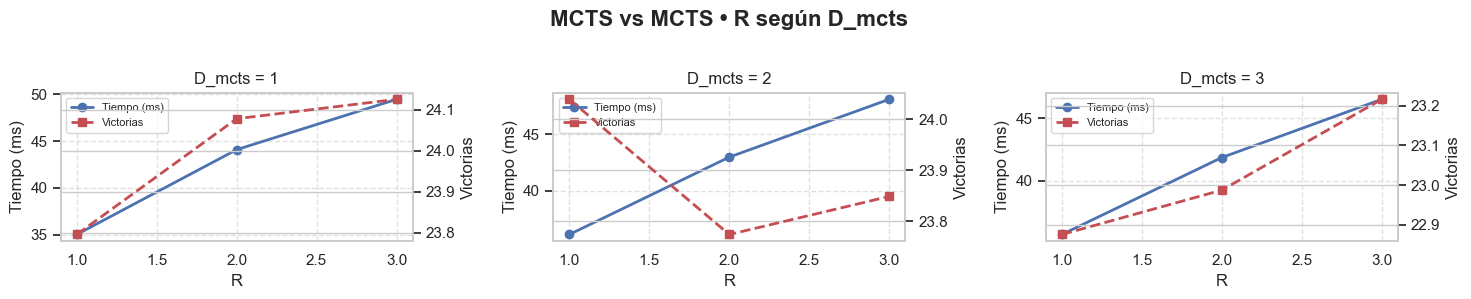

→ Guardado en analisis_tateti\curvas_mcts_vs_mcts_R_por_D_mcts.png


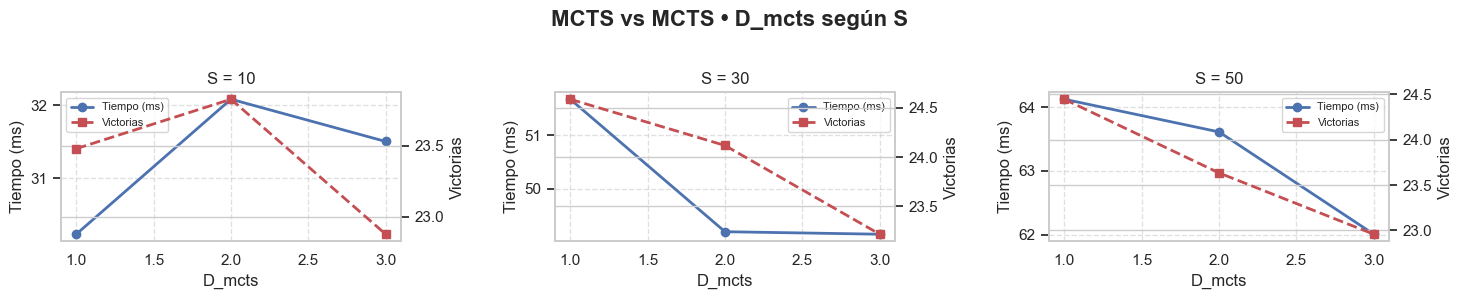

→ Guardado en analisis_tateti\curvas_mcts_vs_mcts_D_mcts_por_S.png


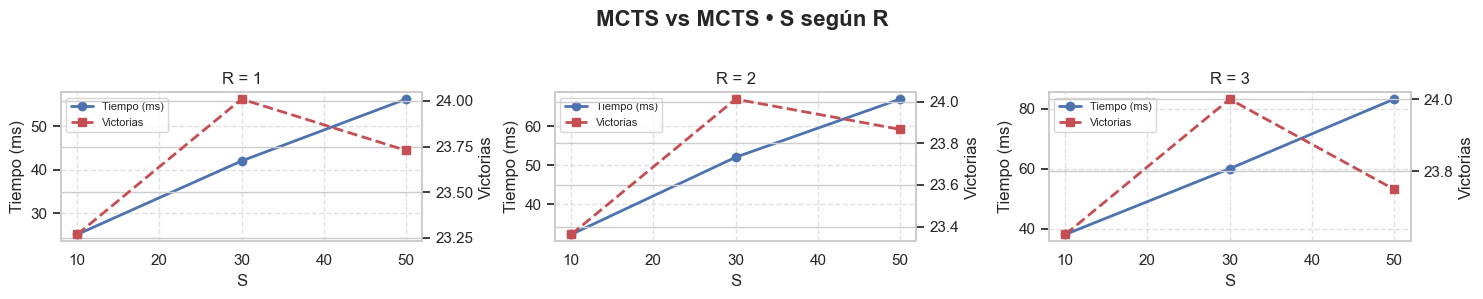

→ Guardado en analisis_tateti\curvas_mcts_vs_mcts_S_por_R.png


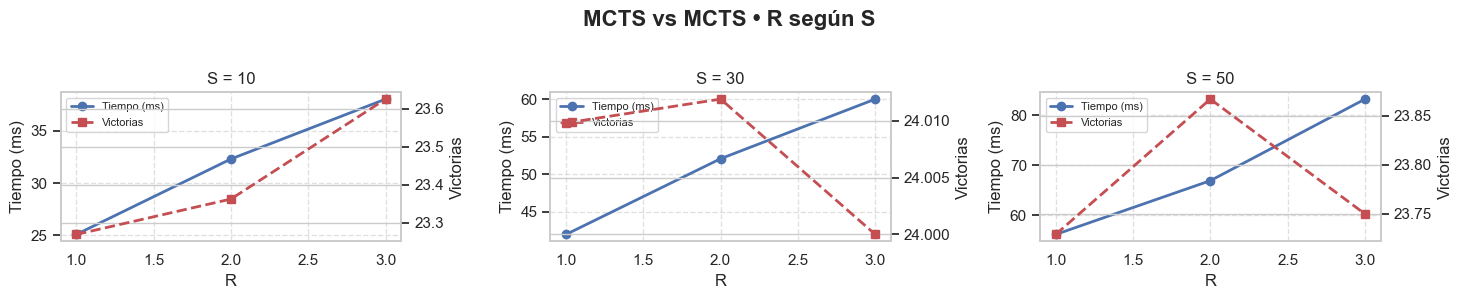

→ Guardado en analisis_tateti\curvas_mcts_vs_mcts_R_por_S.png


In [24]:
def plot_curvas_mcts_vs_mcts(
    data: pd.DataFrame,
    param_x: str,
    param_fixed: str,
    output_dir: str,
    max_cols=3,
    figsize_each=(5, 3)
):
    import math
    df = data.copy()
    agg = (df
           .groupby([param_fixed, param_x], as_index=False)
           .agg({"Total Wins": "mean", "Average Time (ms)": "mean"}))

    fixed_values = sorted(agg[param_fixed].unique())
    n_panels = len(fixed_values)
    n_cols = min(max_cols, n_panels)
    n_rows = math.ceil(n_panels / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize_each[0]*n_cols, figsize_each[1]*n_rows), squeeze=False)

    for idx, fixed_val in enumerate(fixed_values):
        r, c = divmod(idx, n_cols)
        ax_time = axes[r][c]
        sub = agg[agg[param_fixed] == fixed_val].sort_values(param_x)

        # Tiempo
        line1 = ax_time.plot(sub[param_x], sub["Average Time (ms)"], marker="o", label="Tiempo (ms)", lw=2)

        # Winrate (en segundo eje)
        ax_win = ax_time.twinx()
        line2 = ax_win.plot(sub[param_x], sub["Total Wins"], marker="s", linestyle="--", color="C3", label="Victorias", lw=2)

        ax_time.set_title(f"{param_fixed} = {fixed_val}")
        ax_time.set_xlabel(param_x)
        ax_time.set_ylabel("Tiempo (ms)")
        ax_win.set_ylabel("Victorias")

        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax_time.legend(lines, labels, loc="best", fontsize=8)
        ax_time.grid(True, linestyle="--", alpha=0.6)

    for idx in range(n_panels, n_rows * n_cols):
        r, c = divmod(idx, n_cols)
        axes[r][c].axis("off")

    plt.suptitle(f"MCTS vs MCTS • {param_x} según {param_fixed}", fontsize=16, weight="bold", y=0.99)
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    os.makedirs(output_dir, exist_ok=True)
    path = os.path.join(output_dir, f"curvas_mcts_vs_mcts_{param_x}_por_{param_fixed}.png")
    plt.savefig(path, dpi=300)
    plt.show()
    print("→ Guardado en", path)

# Barrer S, un panel por cada profundidad D_mcts
plot_curvas_mcts_vs_mcts(df_mcts_vs_mcts, param_x="S", param_fixed="D_mcts", output_dir=OUTPUT_DIR)
plot_curvas_mcts_vs_mcts(df_mcts_vs_mcts, param_x="D_mcts", param_fixed="R", output_dir=OUTPUT_DIR)
plot_curvas_mcts_vs_mcts(df_mcts_vs_mcts, param_x="R", param_fixed="D_mcts", output_dir=OUTPUT_DIR)
plot_curvas_mcts_vs_mcts(df_mcts_vs_mcts, param_x="D_mcts", param_fixed="S", output_dir=OUTPUT_DIR)
plot_curvas_mcts_vs_mcts(df_mcts_vs_mcts, param_x="S", param_fixed="R", output_dir=OUTPUT_DIR)
plot_curvas_mcts_vs_mcts(df_mcts_vs_mcts, param_x="R", param_fixed="S", output_dir=OUTPUT_DIR)

